# Run Ref

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [2]:
site = 'byl'
site_longname = 'Bylot Island, Canadian high Arctic'
y_start = 2014
y_end = 2018

labels = ['Ref', '30min']

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [3]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_'+labels[0]+'.nc')

In [4]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [5]:
for i in range(len(labels)):
    ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

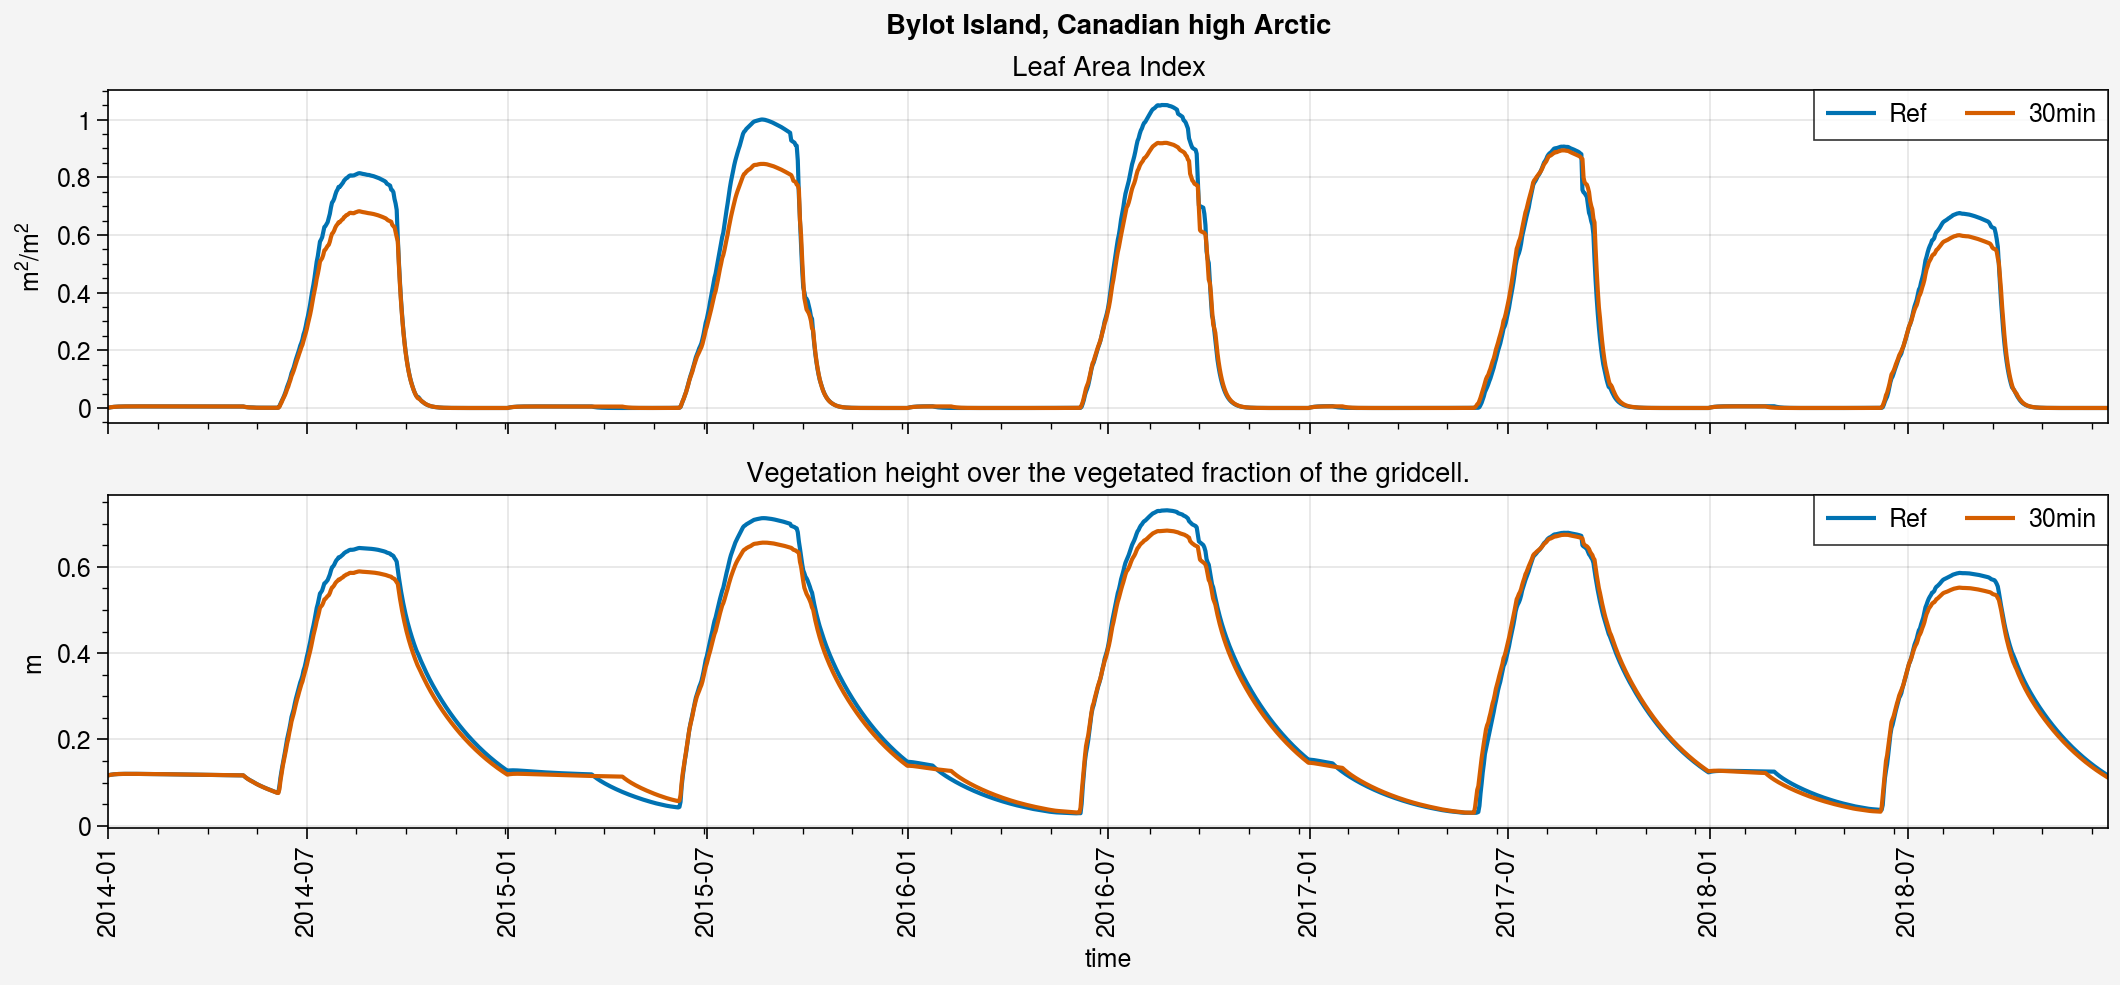

In [6]:
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic (2014-2018)')

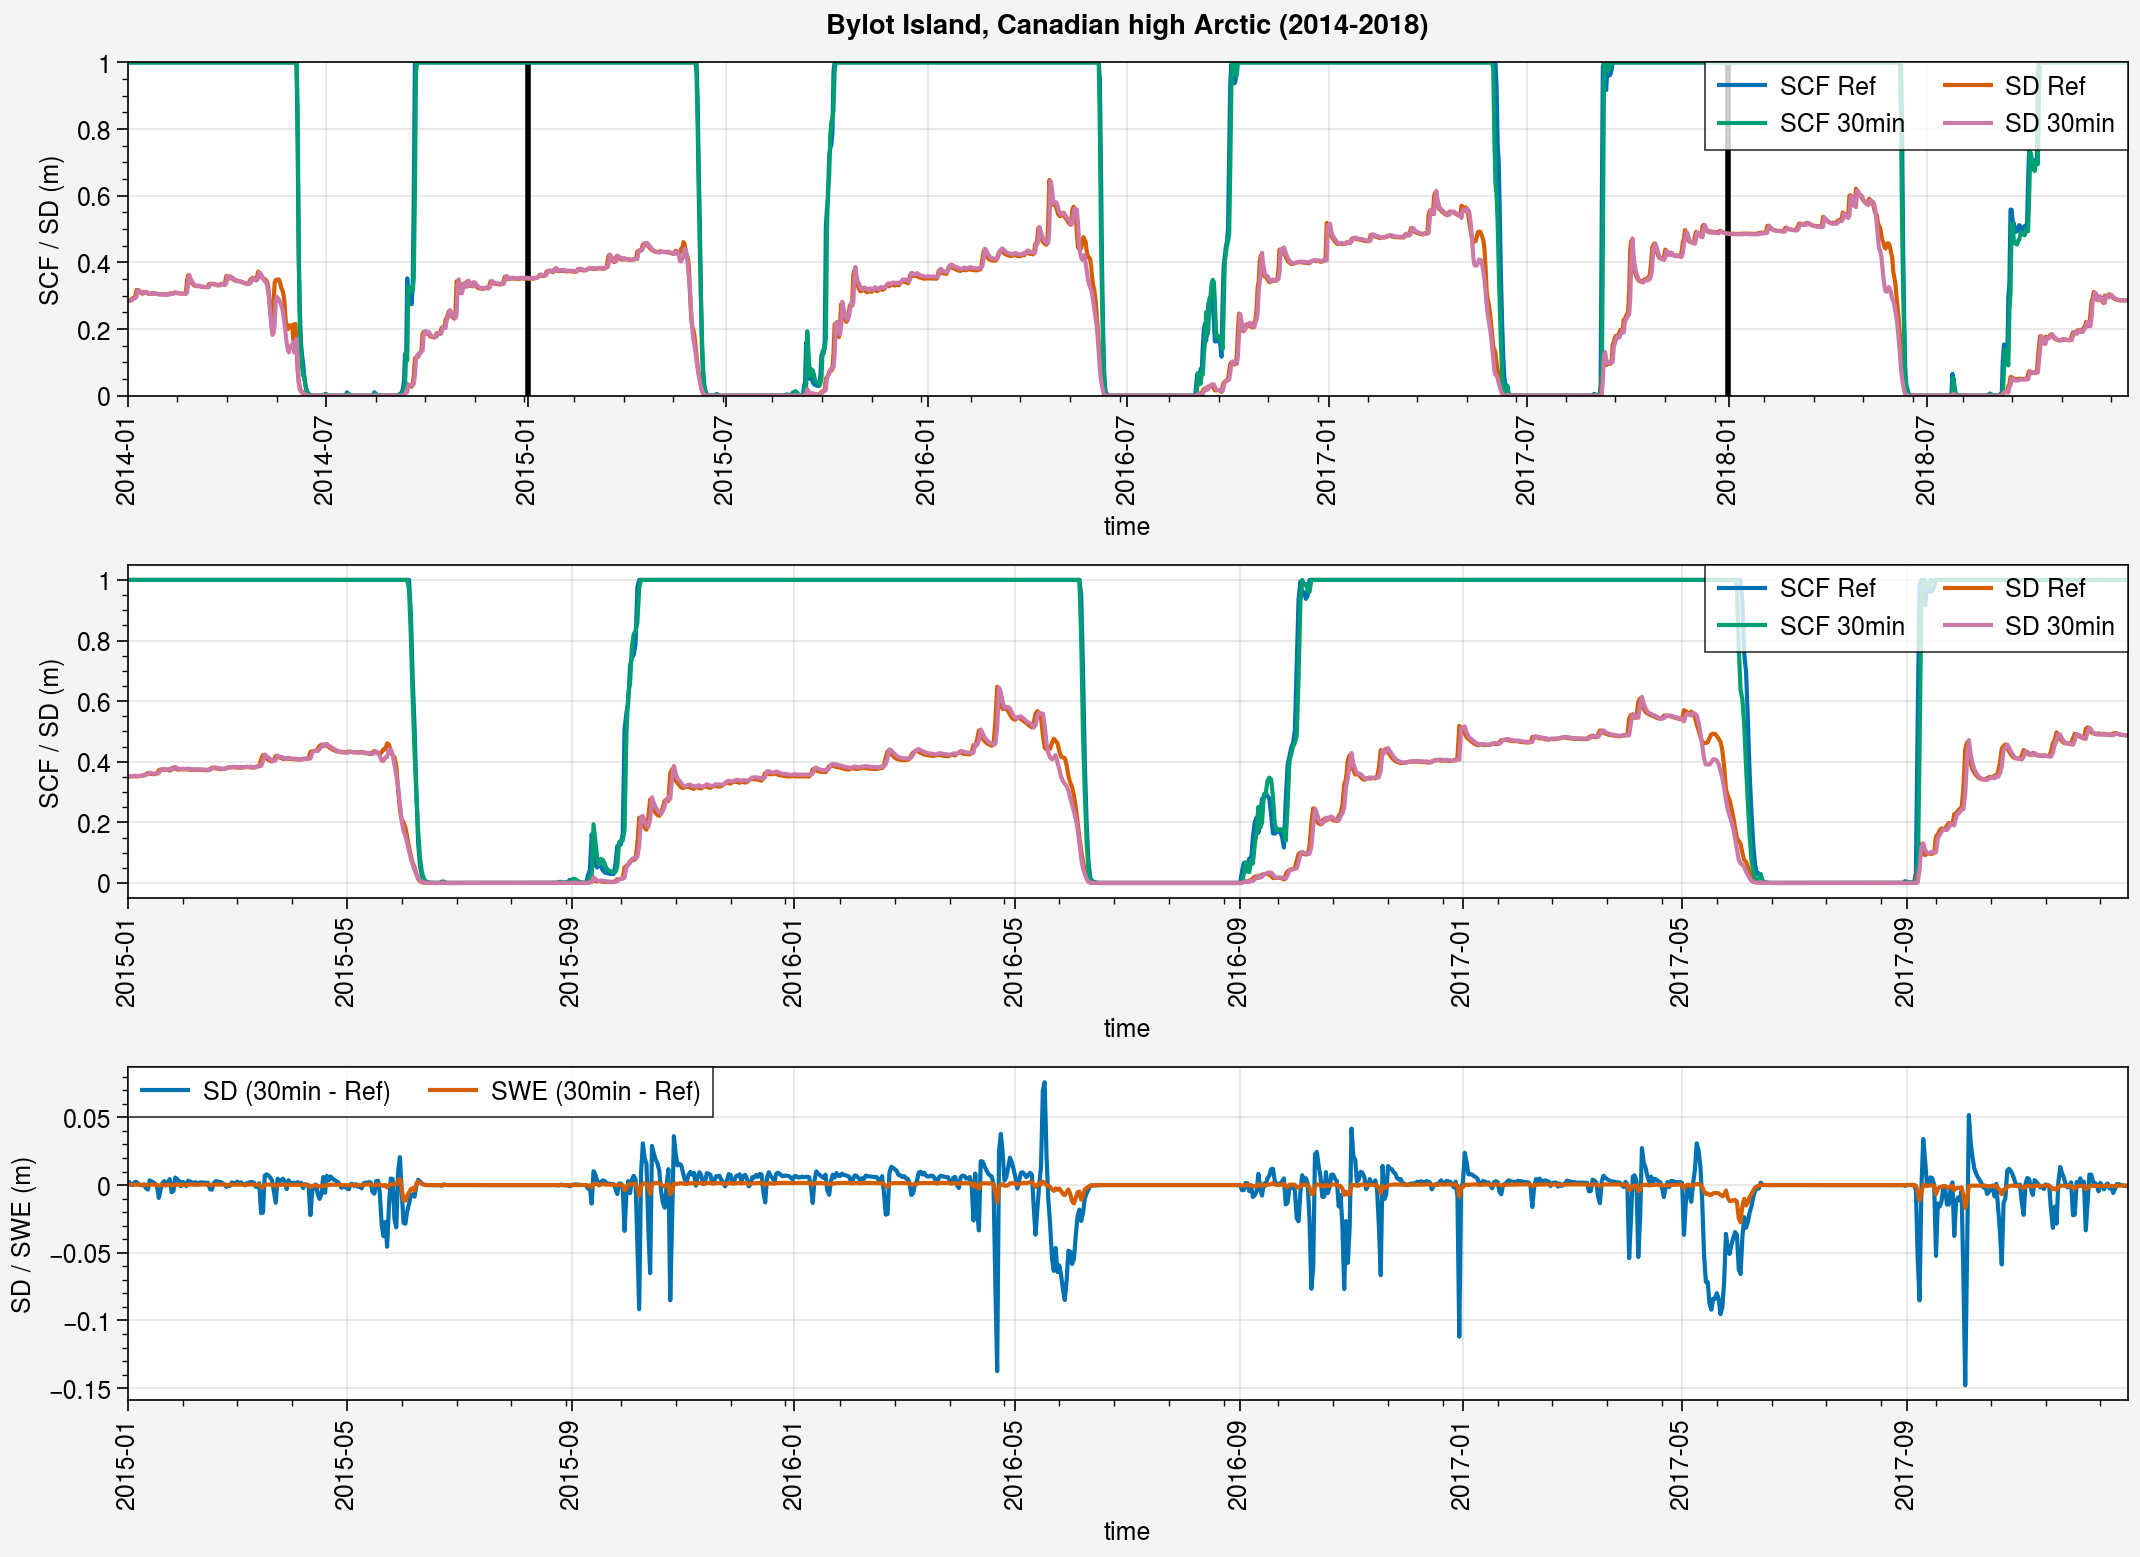

In [7]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+1)
end = str(y_end-1)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


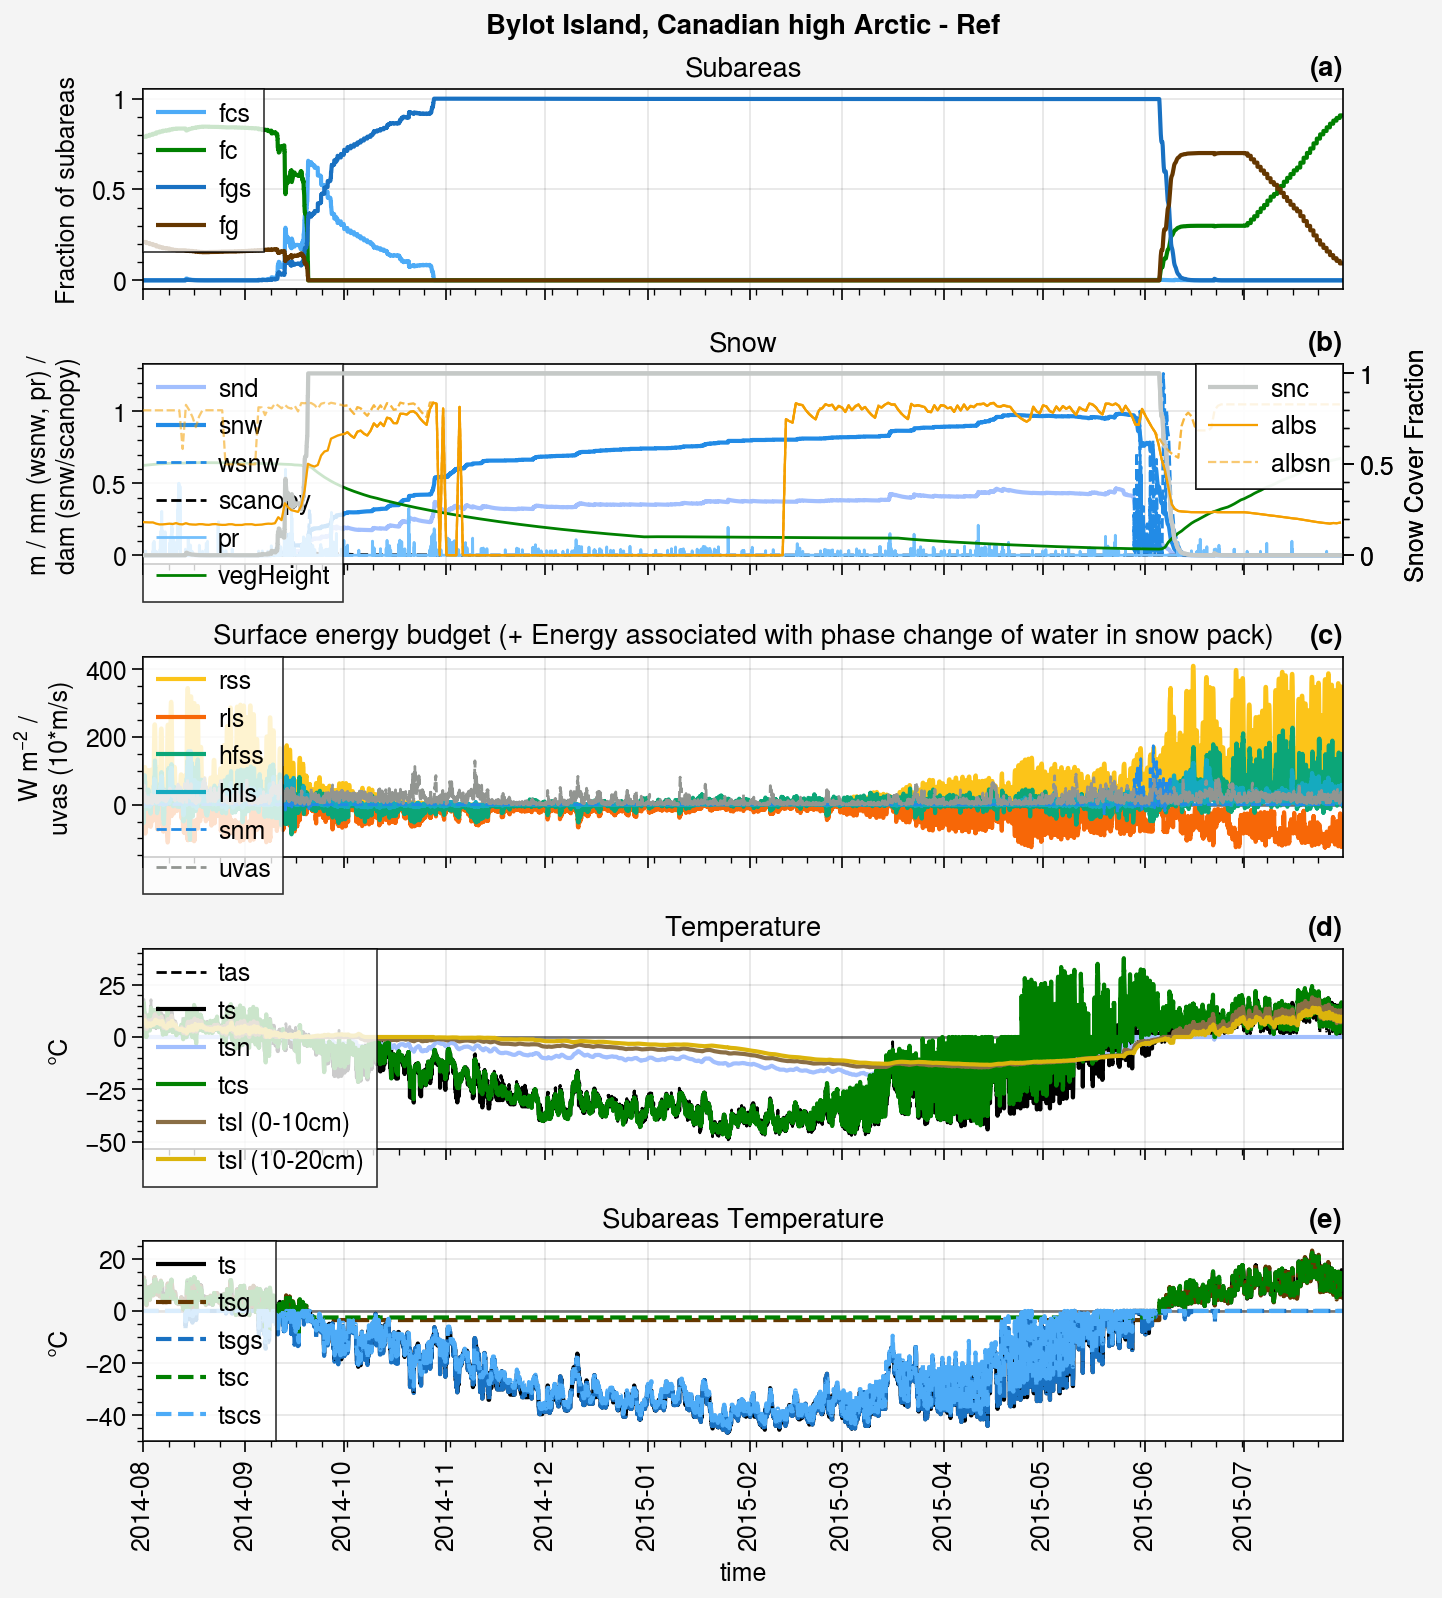

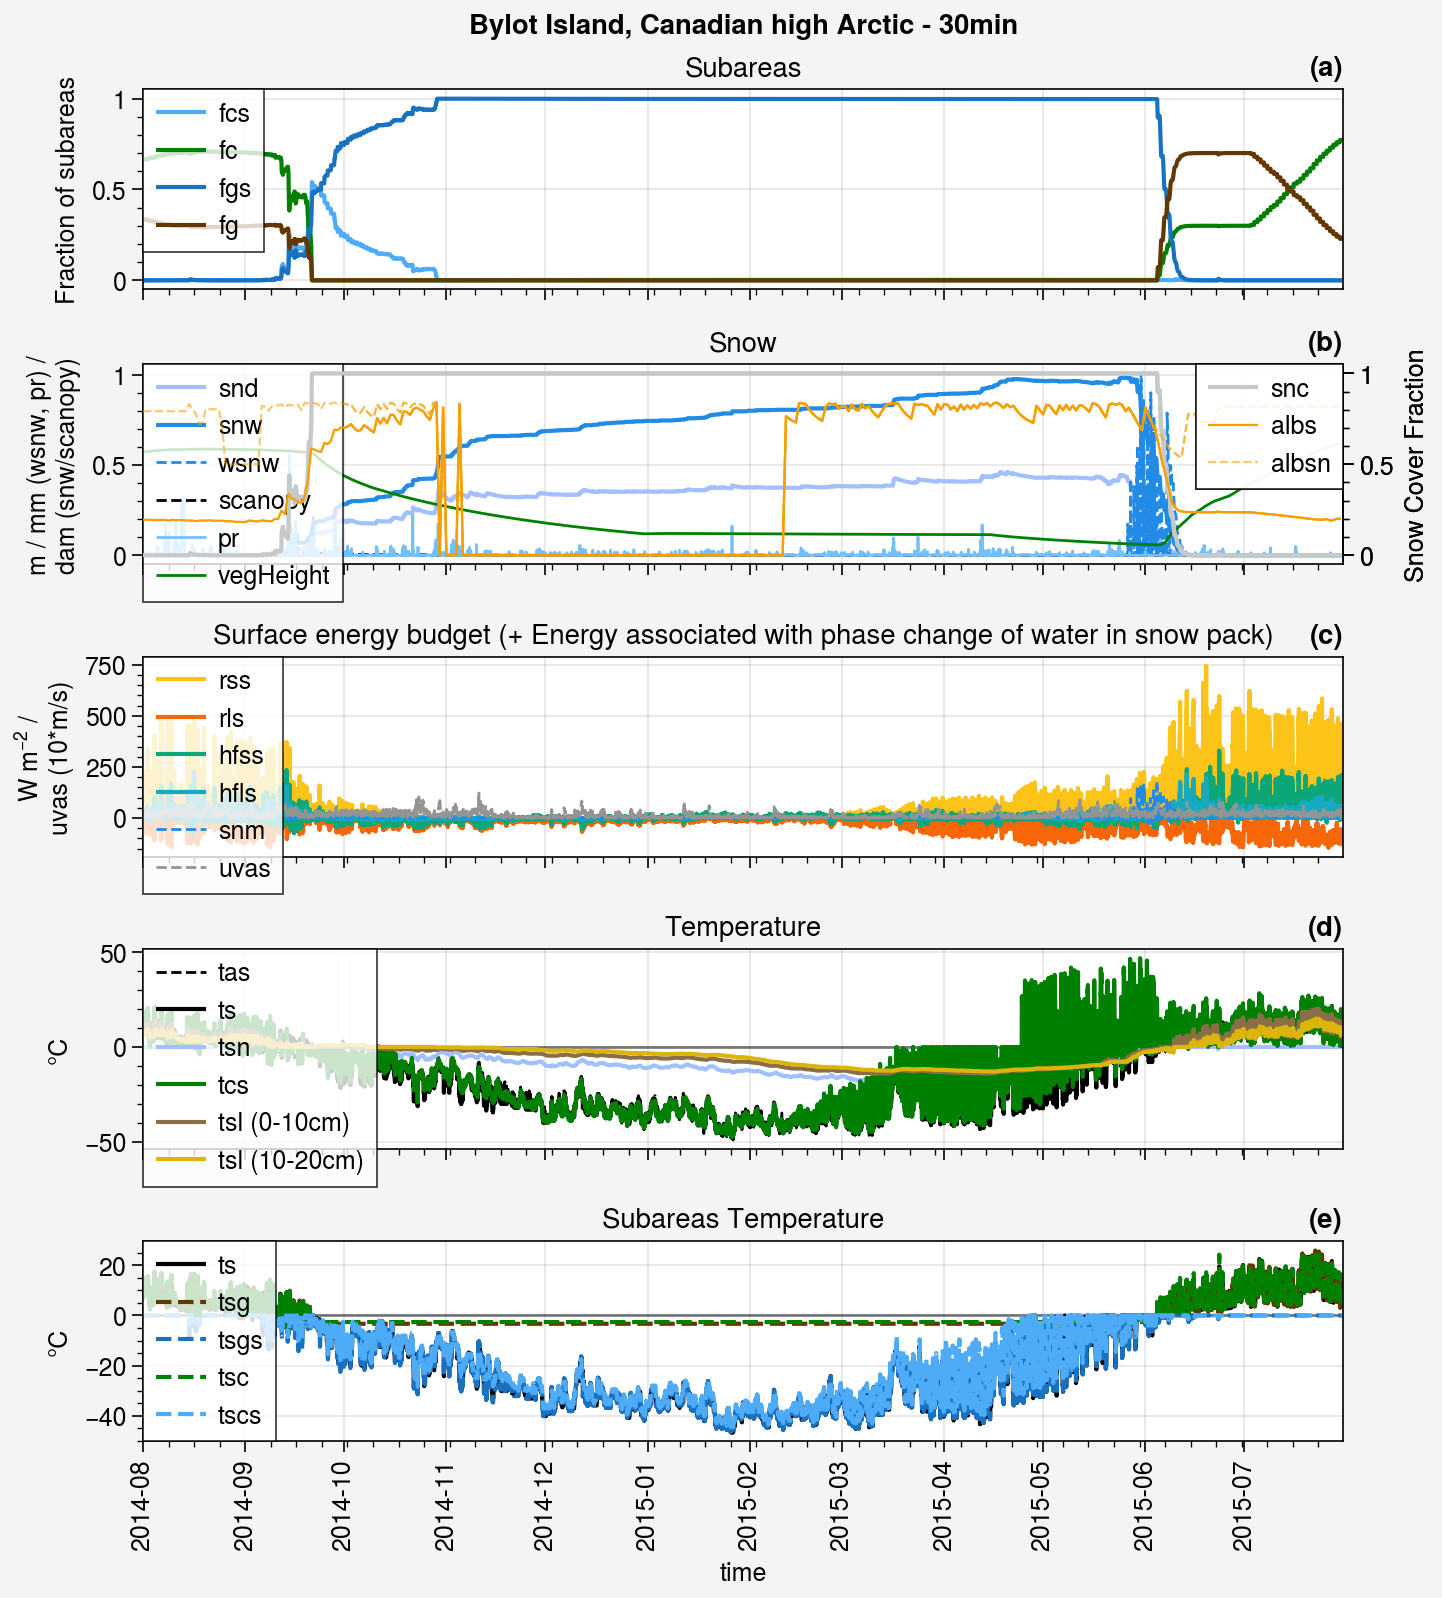

In [8]:
for period in [
    slice(str(y_start)+'-08-01', str(y_start+1)+'-07-30'),
]:

    collabels = labels
    for i, (ds, ds_d) in enumerate(zip(ds_hh_list, ds_d_list)):
        
        fig, axs = pplt.subplots(ncols=1, nrows=5, refaspect=6, refwidth=6, sharey=0)
    
        #############################
        ### Fractions of subareas ###
        #############################

        variables = {
            'fcs': {'color': 'blue4', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fc': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fgs': {'color': 'blue8', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fg': {'color': 'brown', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }

        ax = axs[0]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='Fraction of subareas', title='Subareas', ylim=(-0.05,1.05))

        ##############################
        ### Snow related variables ###
        ##############################

        variables = {
            'snd': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'snw': {'color': 'blue6', 'ls': '-', 'lw': 1.5, 'factor': 1e-3*10, 'shift': 0},
            'wsnw': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'scanopy': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1e-3*10, 'shift': 0},
            'pr': {'color': 'blue3', 'ls': '-', 'lw': 1, 'factor': 500, 'shift': 0},
        #     'albs': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
    #         'mrron': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
        #     'snm': {'color': 'blue8', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
        }

        ax = axs[1]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.plot(ds_d.vegHeight.sel(time=period), label=ds_d.vegHeight.name, color='green', ls='-', lw=1)
        # ax.plot(ds_d.lai.sel(time=period), label='LAI', color='green', ls='-', lw=1)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='m / mm (wsnw, pr) /\ndam (snw/scanopy)', title='Snow')

        variables = {
            'snc': {'color': 'silver', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }
        ox = ax.alty(label='Snow Cover Fraction')
        for key in variables.keys():
            ox.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ox.plot(ds_d.albs.sel(time=period), label='albs', color='yellow7', ls='-', lw=0.8)
        ox.plot(ds_d.albsn.sel(time=period), label='albsn', color='yellow7', ls='--', lw=0.8, alpha=0.5)
        ox.legend(ncols=1, loc='ur')
        ox.format(ylim=(-0.05,1.05))


        ##############################
        ### Surface energy budget ###
        ##############################

        variables = {
            'rss': {'color': 'yellow5', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'rls': {'color': 'orange7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        #     'rlds': {'color': 'orange7', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'hfss': {'color': 'teal7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'hfls': {'color': 'cyan6', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'snm': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'uvas': {'color': 'gray', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
        }

        ax = axs[2]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='W m$^{-2}$ /\nuvas (10*m/s)', title='Surface energy budget (+ Energy associated with phase change of water in snow pack)')


        ###################
        ### Temperature ###
        ###################

        variables = {
            'tas': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 273.15},
            'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},    
            'tsn': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'tcs': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }

        ax = axs[3]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=0), label=ds.tsl.name+' (0-10cm)', color='dirt')
        ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=1), label=ds.tsl.name+' (10-20cm)', color='gold')
        # ax.plot(ds_h_eval_menard2019.ts.sel(time=period), color='red', label='ts obs')
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='°C', title='Temperature')

        


        ############################
        ### Subareas Temperature ###
        ############################

        variables = {
            'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},

            'tsg': {'color': 'brown', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tsgs': {'color': 'blue8', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tsc': {'color': 'green', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tscs': {'color': 'blue4', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
        }

        ax = axs[4]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='°C', title='Subareas Temperature')

        fig.suptitle(site_longname+' - '+collabels[i])
        fig.format(abc='(a)', abcloc='r')
        # fig.save('img/'+labels[i]+'_hh.jpg')

## Compare with obs

In [9]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'

ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_'+str(y_start-1)+'_'+str(y_end+1)+'.nc').load()
ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_met = xr.open_dataset(path_obs+'/met_insitu_'+site+'_'+str(y_start-1)+'_'+str(y_end+1)+'.nc').load()

ds_h_obs

<xarray.Dataset>
Dimensions:         (time: 52202, sdepth: 5, sheight: 10)
Coordinates:
  * time            (time) datetime64[ns] 2013-07-11T09:00:00 ... 2019-06-25T...
  * sdepth          (sdepth) float64 0.02 0.05 0.1 0.15 0.21
  * sheight         (sheight) float64 0.0 0.02 0.05 0.07 ... 0.25 0.27 0.35 0.37
Data variables:
    snd_auto        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    albs            (time) float64 0.16 0.15 0.17 0.16 ... 0.16 0.17 0.16 0.16
    flag_albs_ERA5  (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ts              (time) float64 9.86 10.42 13.45 14.11 ... 10.71 14.89 nan
    mrsll           (sdepth, time) float64 0.2 0.2 0.2 0.2 ... 0.066 0.066 0.066
    tsl             (sdepth, time) float64 3.7 4.3 4.99 5.6 ... -0.3 -0.3 -0.3
    tsnl            (sheight, time) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    reference:    Domine, F., Lackner, G., Sarrazin, D., Poirier, M., & Belke...
    description:  Converted to netCDF (SnowMIP kind of format) from original ...

In [10]:
tot_year = y_end - y_start + 1
gap = 4
years = pplt.arange(y_start, y_end)
years

array([2014, 2015, 2016, 2017, 2018])

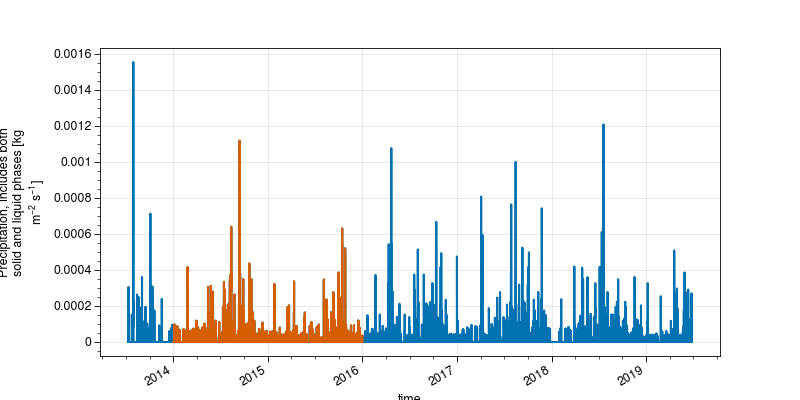

In [11]:
%matplotlib widget
(ds_h_met.Rainf + ds_h_met.Snowf).plot(figsize=(8,4))
ds_hh_list[1].pr.plot()

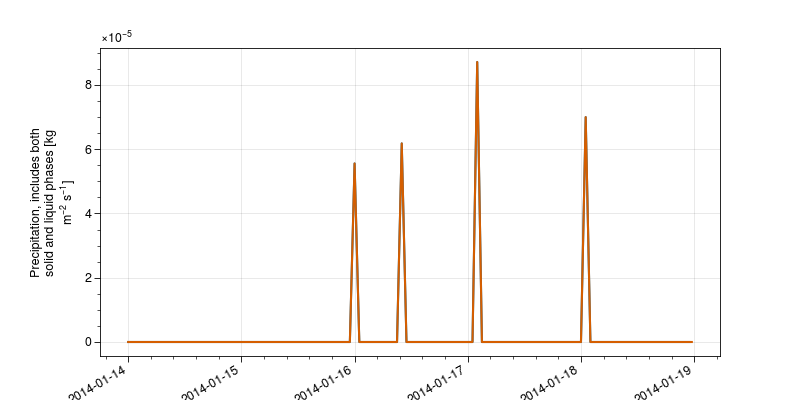

In [12]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
(ds_h_met.Rainf + ds_h_met.Snowf).sel(time=period).plot(figsize=(8,4))
ds_hh_list[1].pr.sel(time=period).plot()
# ds_hh_list[1].pr.sel(time=period).resample(time='H').mean().plot()

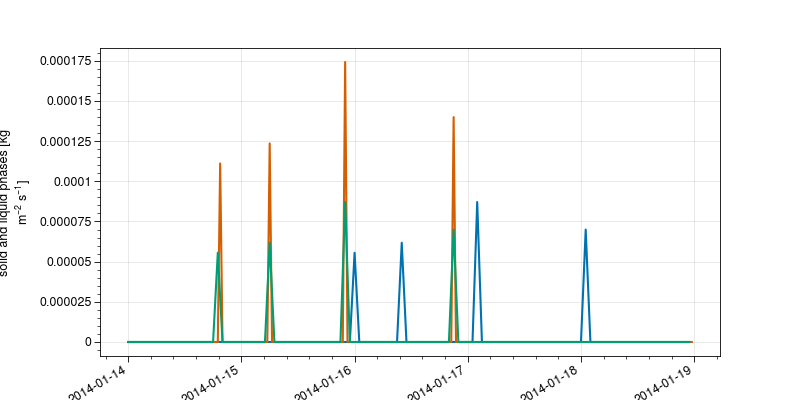

In [13]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
(ds_h_met.Rainf + ds_h_met.Snowf).sel(time=period).plot(figsize=(8,4))
ds_hh_list[0].pr.sel(time=period).plot()
ds_hh_list[0].pr.sel(time=period).resample(time='H').mean().plot()

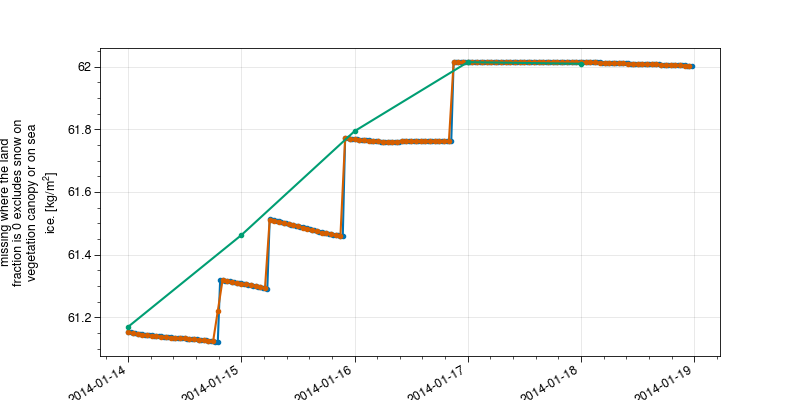

In [14]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
ds_hh_list[0].snw.sel(time=period).plot(figsize=(8,4), marker='.')
ds_hh_list[0].snw.sel(time=period).resample(time='H').mean().plot(marker='.')
ds_hh_list[0].snw.sel(time=period).resample(time='D').mean().plot(marker='.')

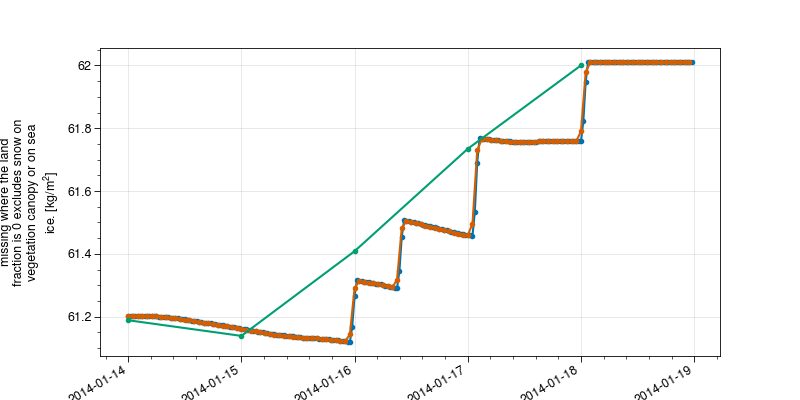

In [15]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
ds_hh_list[1].snw.sel(time=period).plot(figsize=(8,4), marker='.')
ds_hh_list[1].snw.sel(time=period).resample(time='H').mean().plot(marker='.')
ds_hh_list[1].snw.sel(time=period).resample(time='D').mean().plot(marker='.')

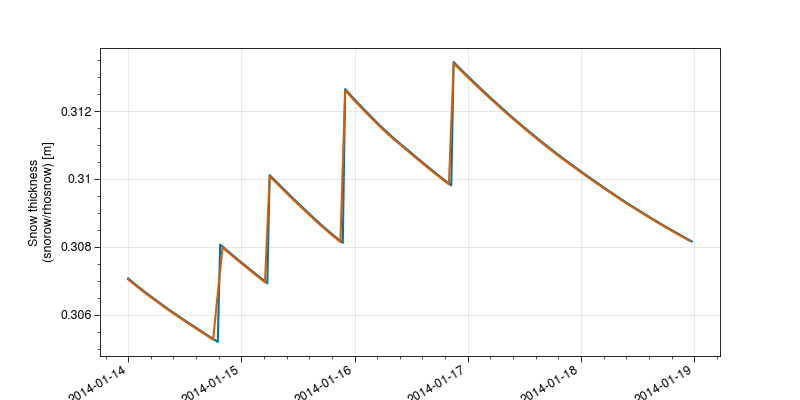

In [16]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
ds_hh_list[0].snd.sel(time=period).plot(figsize=(8,4))
ds_hh_list[0].snd.sel(time=period).resample(time='H').mean().plot()

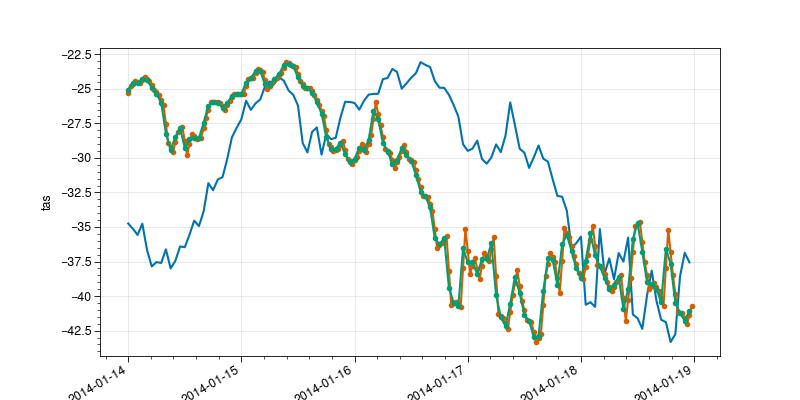

In [17]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
ds_h_met.Tair.sel(time=period).plot(figsize=(8,4))
(ds_hh_list[0].tas.sel(time=period)-273.15).plot(marker='.')
(ds_hh_list[0].tas.sel(time=period)-273.15).resample(time='H').mean().plot(marker='.')

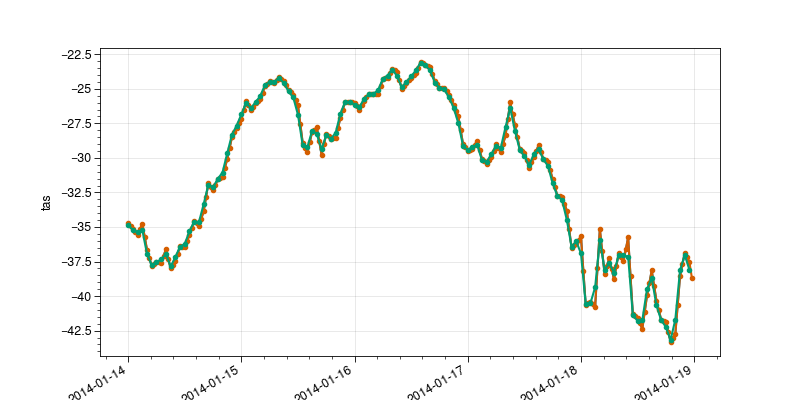

In [18]:
%matplotlib widget
period=slice('2014-01-14', '2014-01-18')
ds_h_met.Tair.sel(time=period).plot(figsize=(8,4))
(ds_hh_list[1].tas.sel(time=period)-273.15).plot(marker='.')
(ds_hh_list[1].tas.sel(time=period)-273.15).resample(time='H').mean().plot(marker='.')

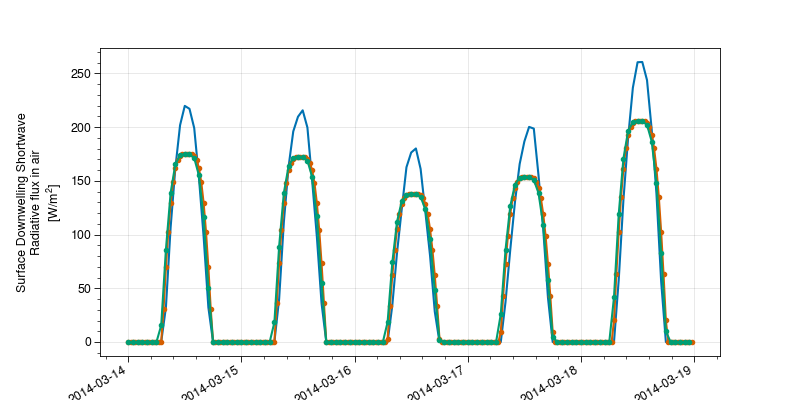

In [19]:
%matplotlib widget
period=slice('2014-03-14', '2014-03-18')
ds_h_met.SWdown.sel(time=period).plot(figsize=(8,4))
ds_hh_list[0].rsds.sel(time=period).plot(marker='.')
ds_hh_list[0].rsds.sel(time=period).resample(time='H').mean().plot(marker='.')

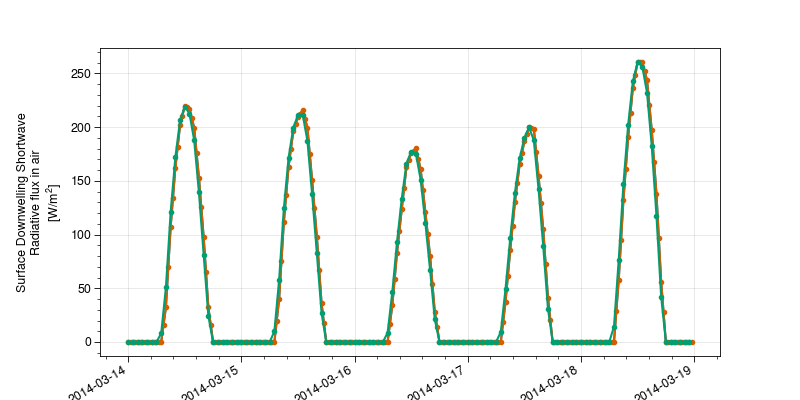

In [20]:
%matplotlib widget
period=slice('2014-03-14', '2014-03-18')
ds_h_met.SWdown.sel(time=period).plot(figsize=(8,4))
ds_hh_list[1].rsds.sel(time=period).plot(marker='.')
ds_hh_list[1].rsds.sel(time=period).resample(time='H').mean().plot(marker='.')

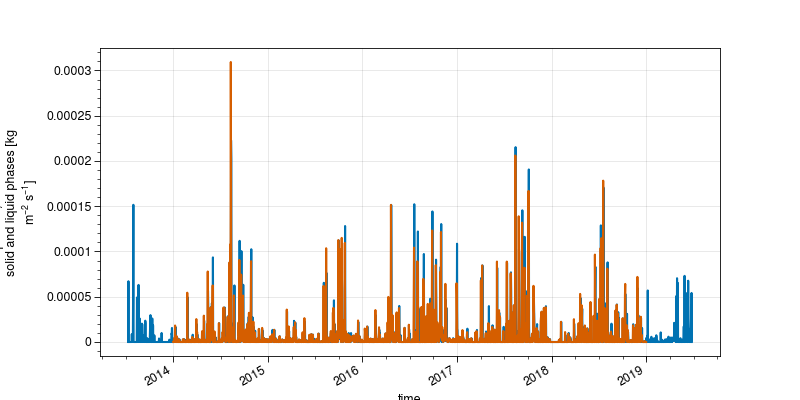

In [21]:
%matplotlib widget
(ds_h_met.Rainf + ds_h_met.Snowf).resample(time='D', origin='start_day').mean().plot(figsize=(8,4))
ds_d_list[0].pr.plot()

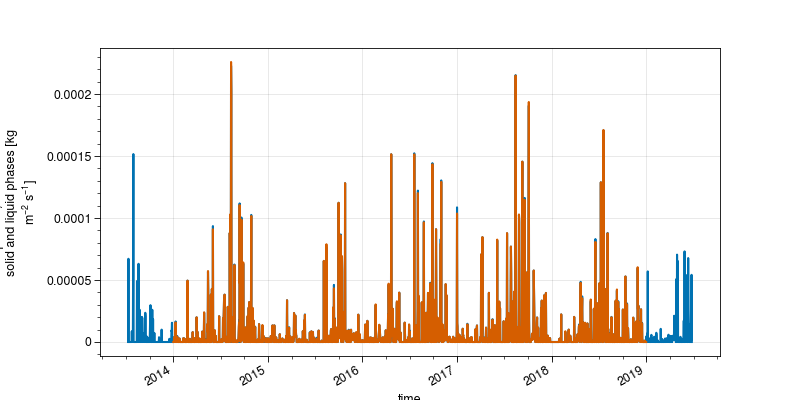

In [22]:
%matplotlib widget
(ds_h_met.Rainf + ds_h_met.Snowf).resample(time='D', origin='start_day').mean().plot(figsize=(8,4))
ds_d_list[1].pr.plot()

### SD

In [106]:
path_SALIX = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/timelapse/SALIX_F'
df_SALIX = pd.read_excel(path_SALIX+'/SnowDepth_SALIX_F.xlsx', skiprows=1, date_format='time_stamp', index_col='time_stamp')
df_SALIX.index.names = ['time']
df_SALIX

TUNDRA  SALIX-F
time                                
2016-07-09 14:00:00     0.0      0.0
2016-07-09 15:00:00     0.0      0.0
2016-07-09 16:00:00     0.0      0.0
2016-07-09 17:00:00     0.0      0.0
2016-07-09 18:00:00     0.0      0.0
...                     ...      ...
2019-07-05 10:00:00     0.0      0.0
2019-07-05 11:00:00     0.0      0.0
2019-07-05 12:00:00     0.0      0.0
2019-07-05 13:00:00     0.0      0.0
2019-07-05 14:00:00     0.0      0.0

[26185 rows x 2 columns]

In [107]:
ds_SALIX = df_SALIX.to_xarray()
ds_SALIX

<xarray.Dataset>
Dimensions:  (time: 26185)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-09T14:00:00 ... 2019-07-05T14:00:00
Data variables:
    TUNDRA   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    SALIX-F  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

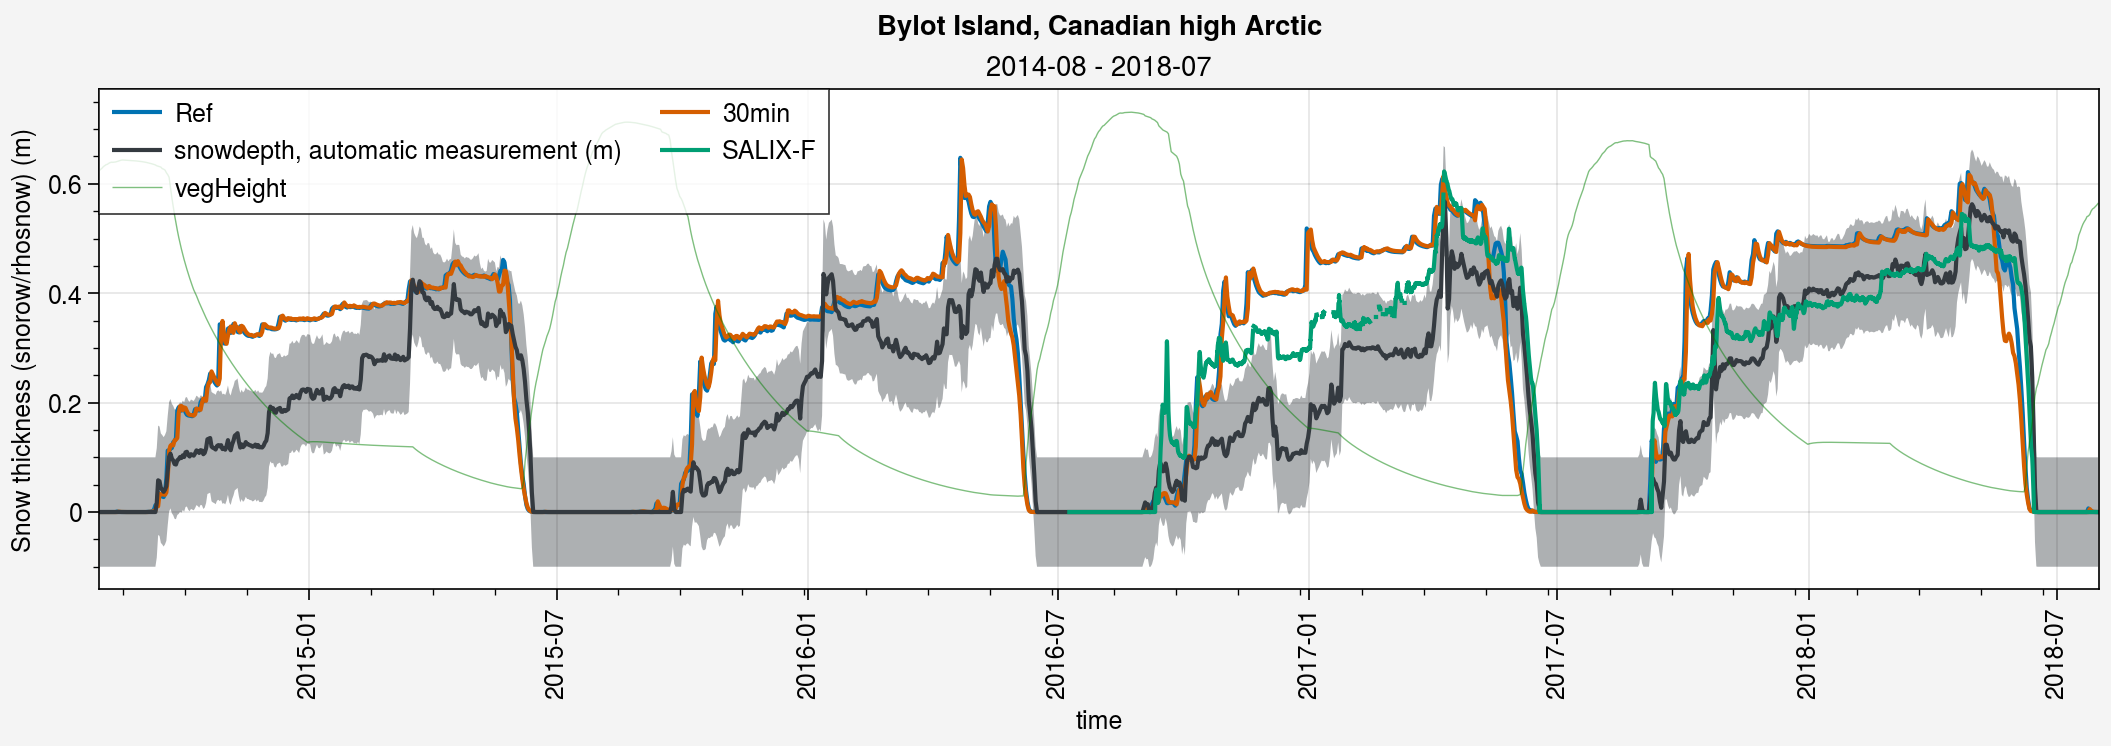

In [110]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

    axs[0].plot(ds_SALIX['SALIX-F'].sel(time=period))
    

    # Veg
    axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


In [25]:
path_forcing = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
forcing = xr.open_dataset(path_forcing+'/met_insitu_'+site+'_2013_2019.nc')

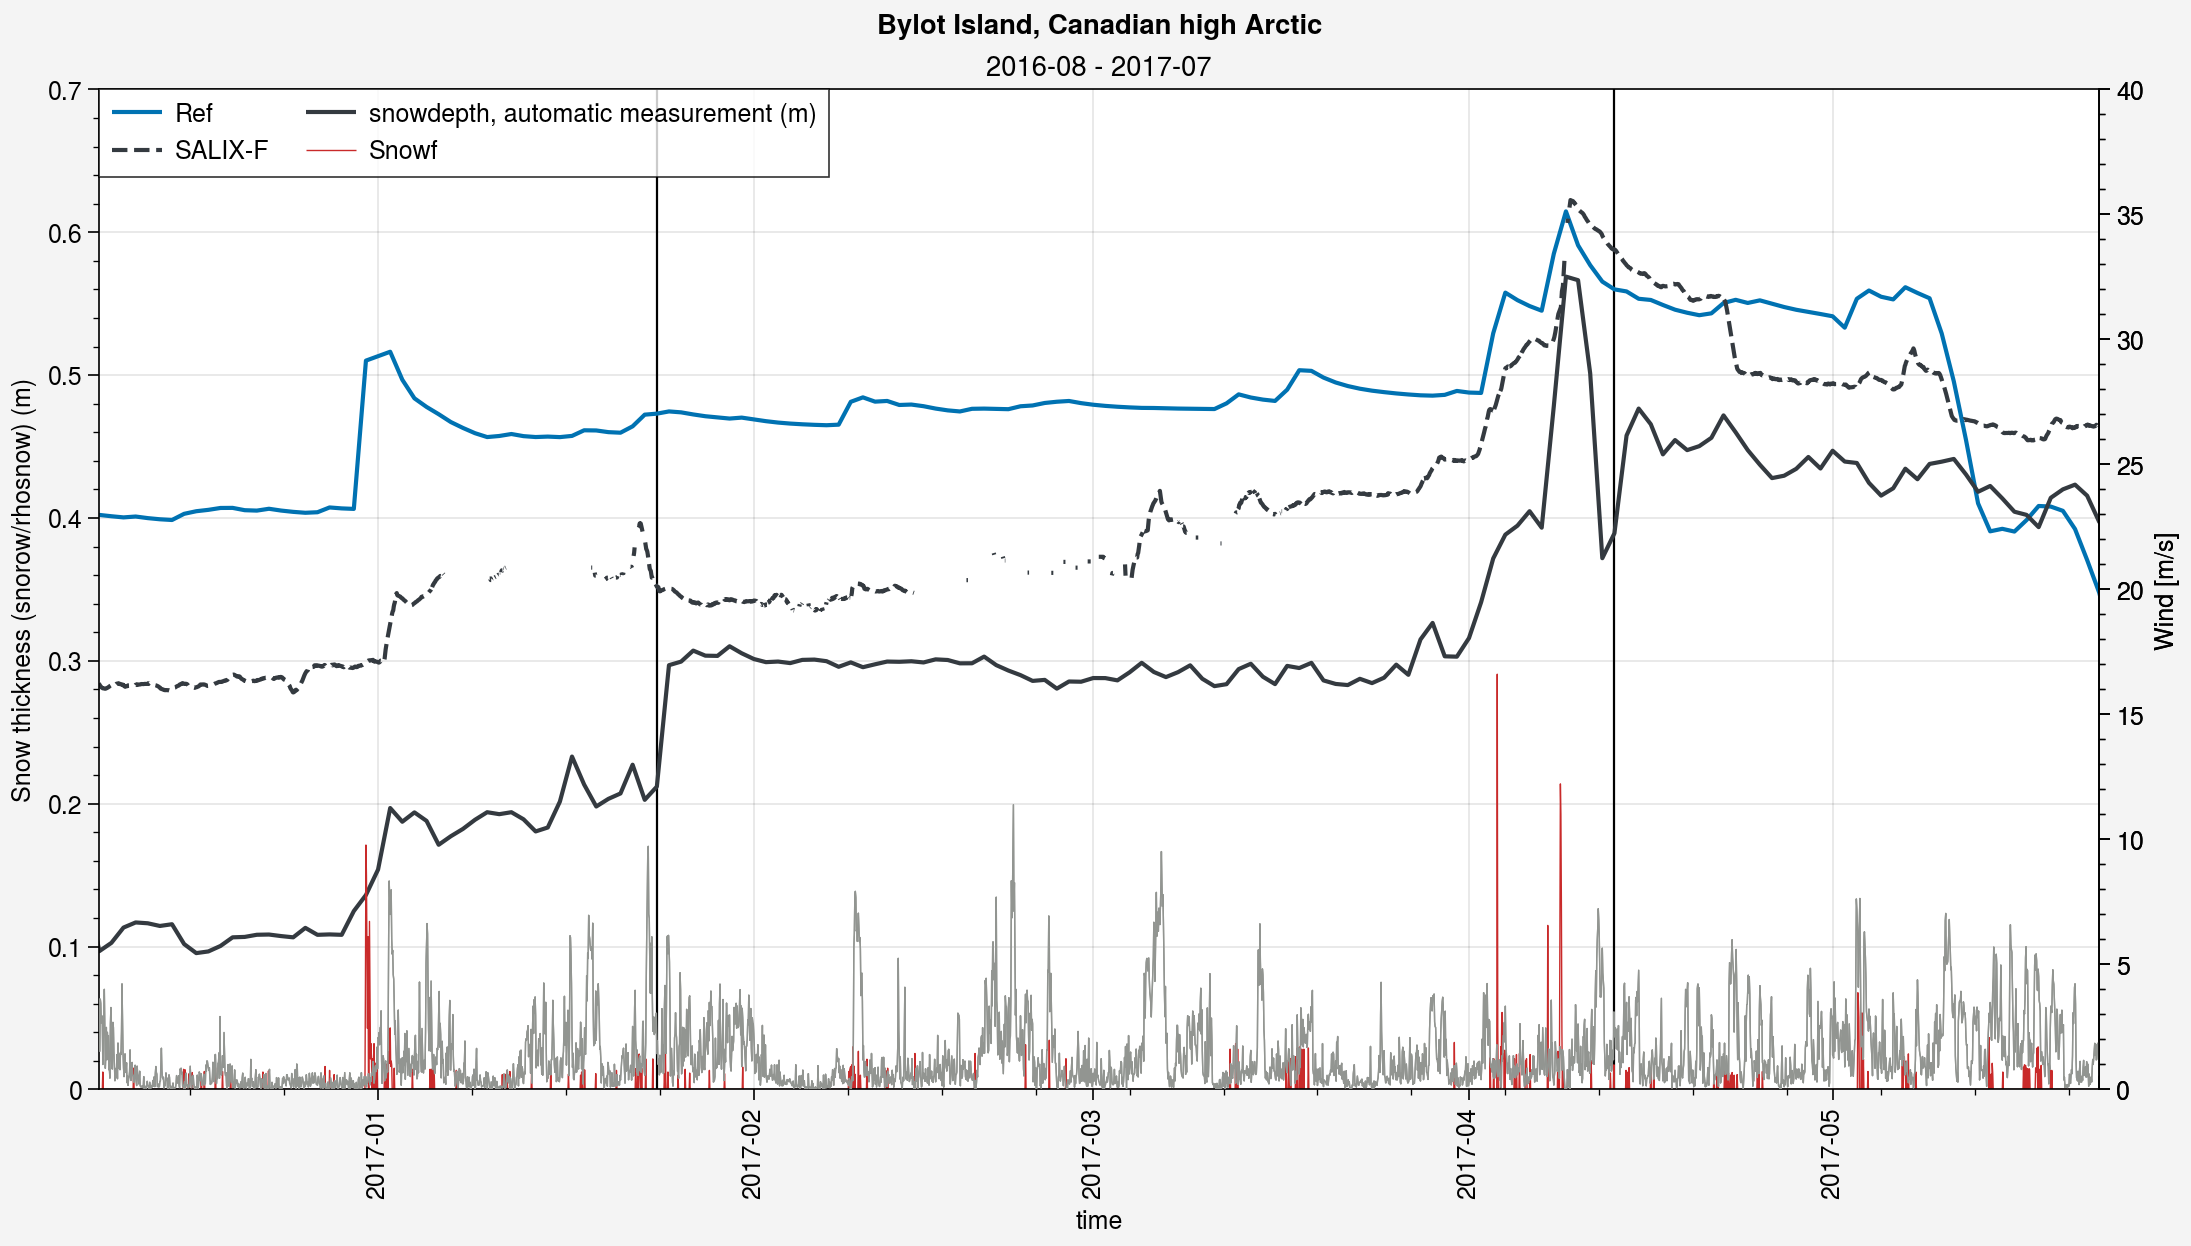

In [120]:
%matplotlib inline

color_obs = 'gray8'

fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=2, refwidth=10)

period=slice('2016-08','2017-07')

# Simus
# for ds_d, label in zip(ds_d_list, labels):
axs[0].plot(ds_d_list[1].snd.sel(time=period), label='Ref')

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), color=color_obs)
axs[0].plot(ds_SALIX['SALIX-F'].sel(time=period), color=color_obs, ls='--')
axs[0].plot(forcing.Snowf.sel(time=period)*360, color='red9', lw=0.5)

ox = axs[0].alty(label='Wind [m/s]')
ox.plot(forcing.Wind.sel(time=period), color='gray', lw=0.5)
ox.format(ylim=(0, 40))

# axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

# for i in range(ds_d_obs.snd_auto.sel(time=period).time.size-1):
#     a = (ds_d.snd.sel(time=period)[i+1] - ds_d.snd.sel(time=period)[i]).values.item(0)
#     b = (ds_d_obs.snd_auto.sel(time=period)[i+1] - ds_d_obs.snd_auto.sel(time=period)[i]).values.item(0)
#     # print('a = '+str(a)+ ' / b = '+str(b))
#     if (a < 0.1) & (b > 0.1):
axs[0].vlines(ds_d.snd.sel(time=period)[74].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[176].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[255].time, 0.7, color='k', lw=0.8)

# Veg
# axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

axs[0].legend(loc='ul', ncols=2)
axs[0].format(title=period.start+' - '+period.stop,
            xlim=(ds_d.snd.sel(time=period)[130].time, ds_d.snd.sel(time=period)[-70].time),
             )

fig.suptitle(site_longname)
fig.save('bylot_snd_2017_ex_zoom_SALIX.pdf')

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

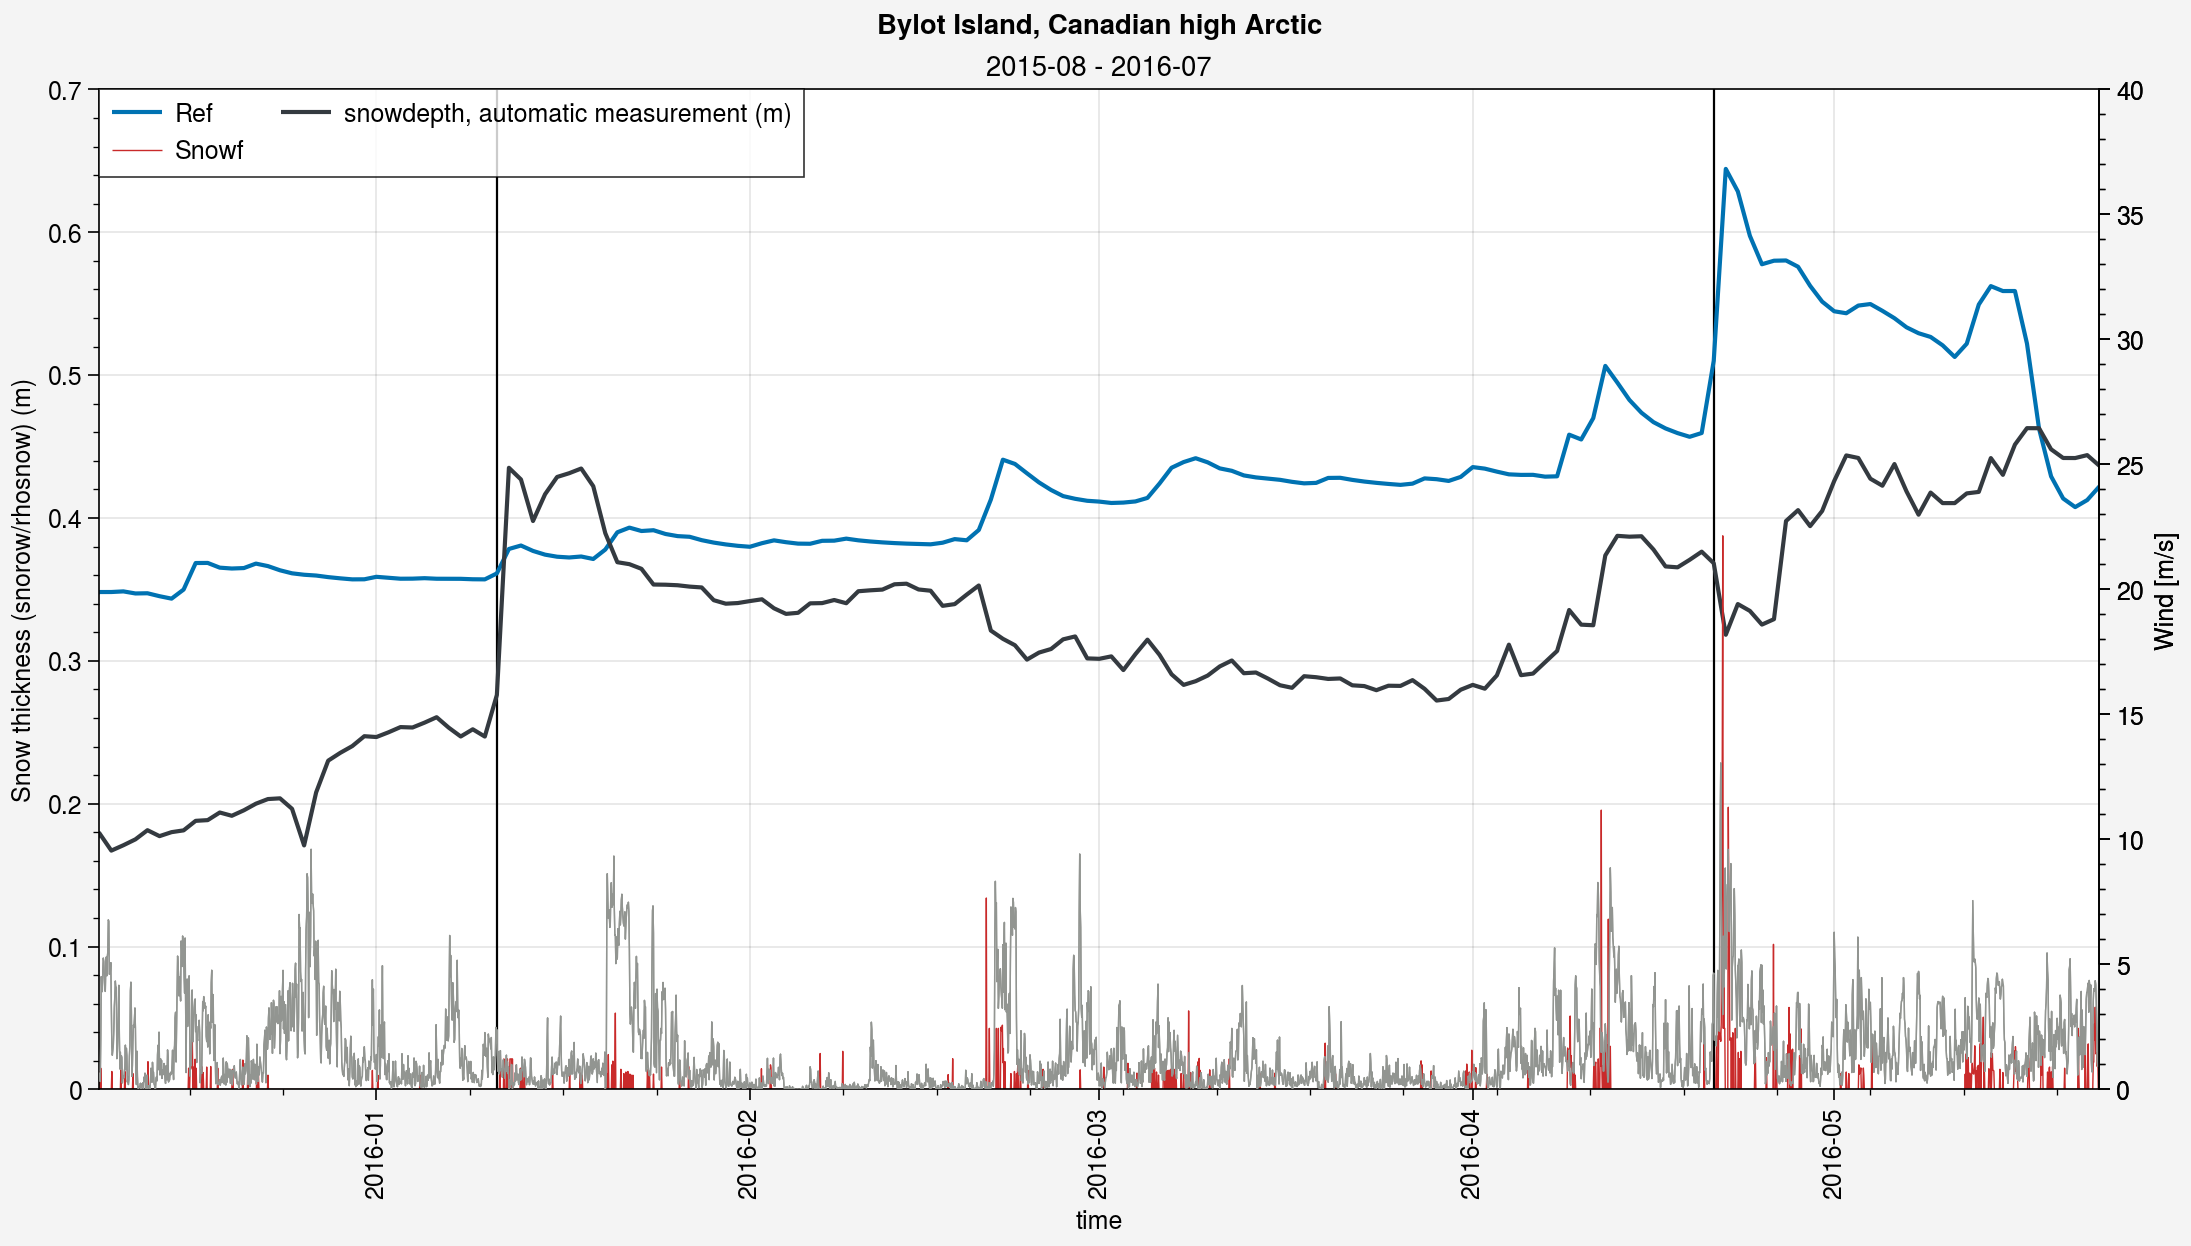

In [81]:
%matplotlib inline

color_obs = 'gray8'

fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=2, refwidth=10)

period=slice('2015-08','2016-07')

# Simus
# for ds_d, label in zip(ds_d_list, labels):
axs[0].plot(ds_d_list[1].snd.sel(time=period), label='Ref')

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), color=color_obs)
axs[0].plot(forcing.Snowf.sel(time=period)*360, color='red9', lw=0.5)

ox = axs[0].alty(label='Wind [m/s]')
ox.plot(forcing.Wind.sel(time=period), color='gray', lw=0.5)
ox.format(ylim=(0, 40))

# axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

# for i in range(ds_d_obs.snd_auto.sel(time=period).time.size-1):
#     a = (ds_d.snd.sel(time=period)[i+1] - ds_d.snd.sel(time=period)[i]).values.item(0)
#     b = (ds_d_obs.snd_auto.sel(time=period)[i+1] - ds_d_obs.snd_auto.sel(time=period)[i]).values.item(0)
#     # print('a = '+str(a)+ ' / b = '+str(b))
#     if (a < 0.1) & (b > 0.1):
axs[0].vlines(ds_d.snd.sel(time=period)[74].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[163].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[264].time, 0.7, color='k', lw=0.8)

# Veg
# axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

axs[0].legend(loc='ul', ncols=2)
axs[0].format(title=period.start+' - '+period.stop,
            xlim=(ds_d.snd.sel(time=period)[130].time, ds_d.snd.sel(time=period)[-70].time),
             )

fig.suptitle(site_longname)
# fig.save('bylot_snd_2016_ex.pdf')

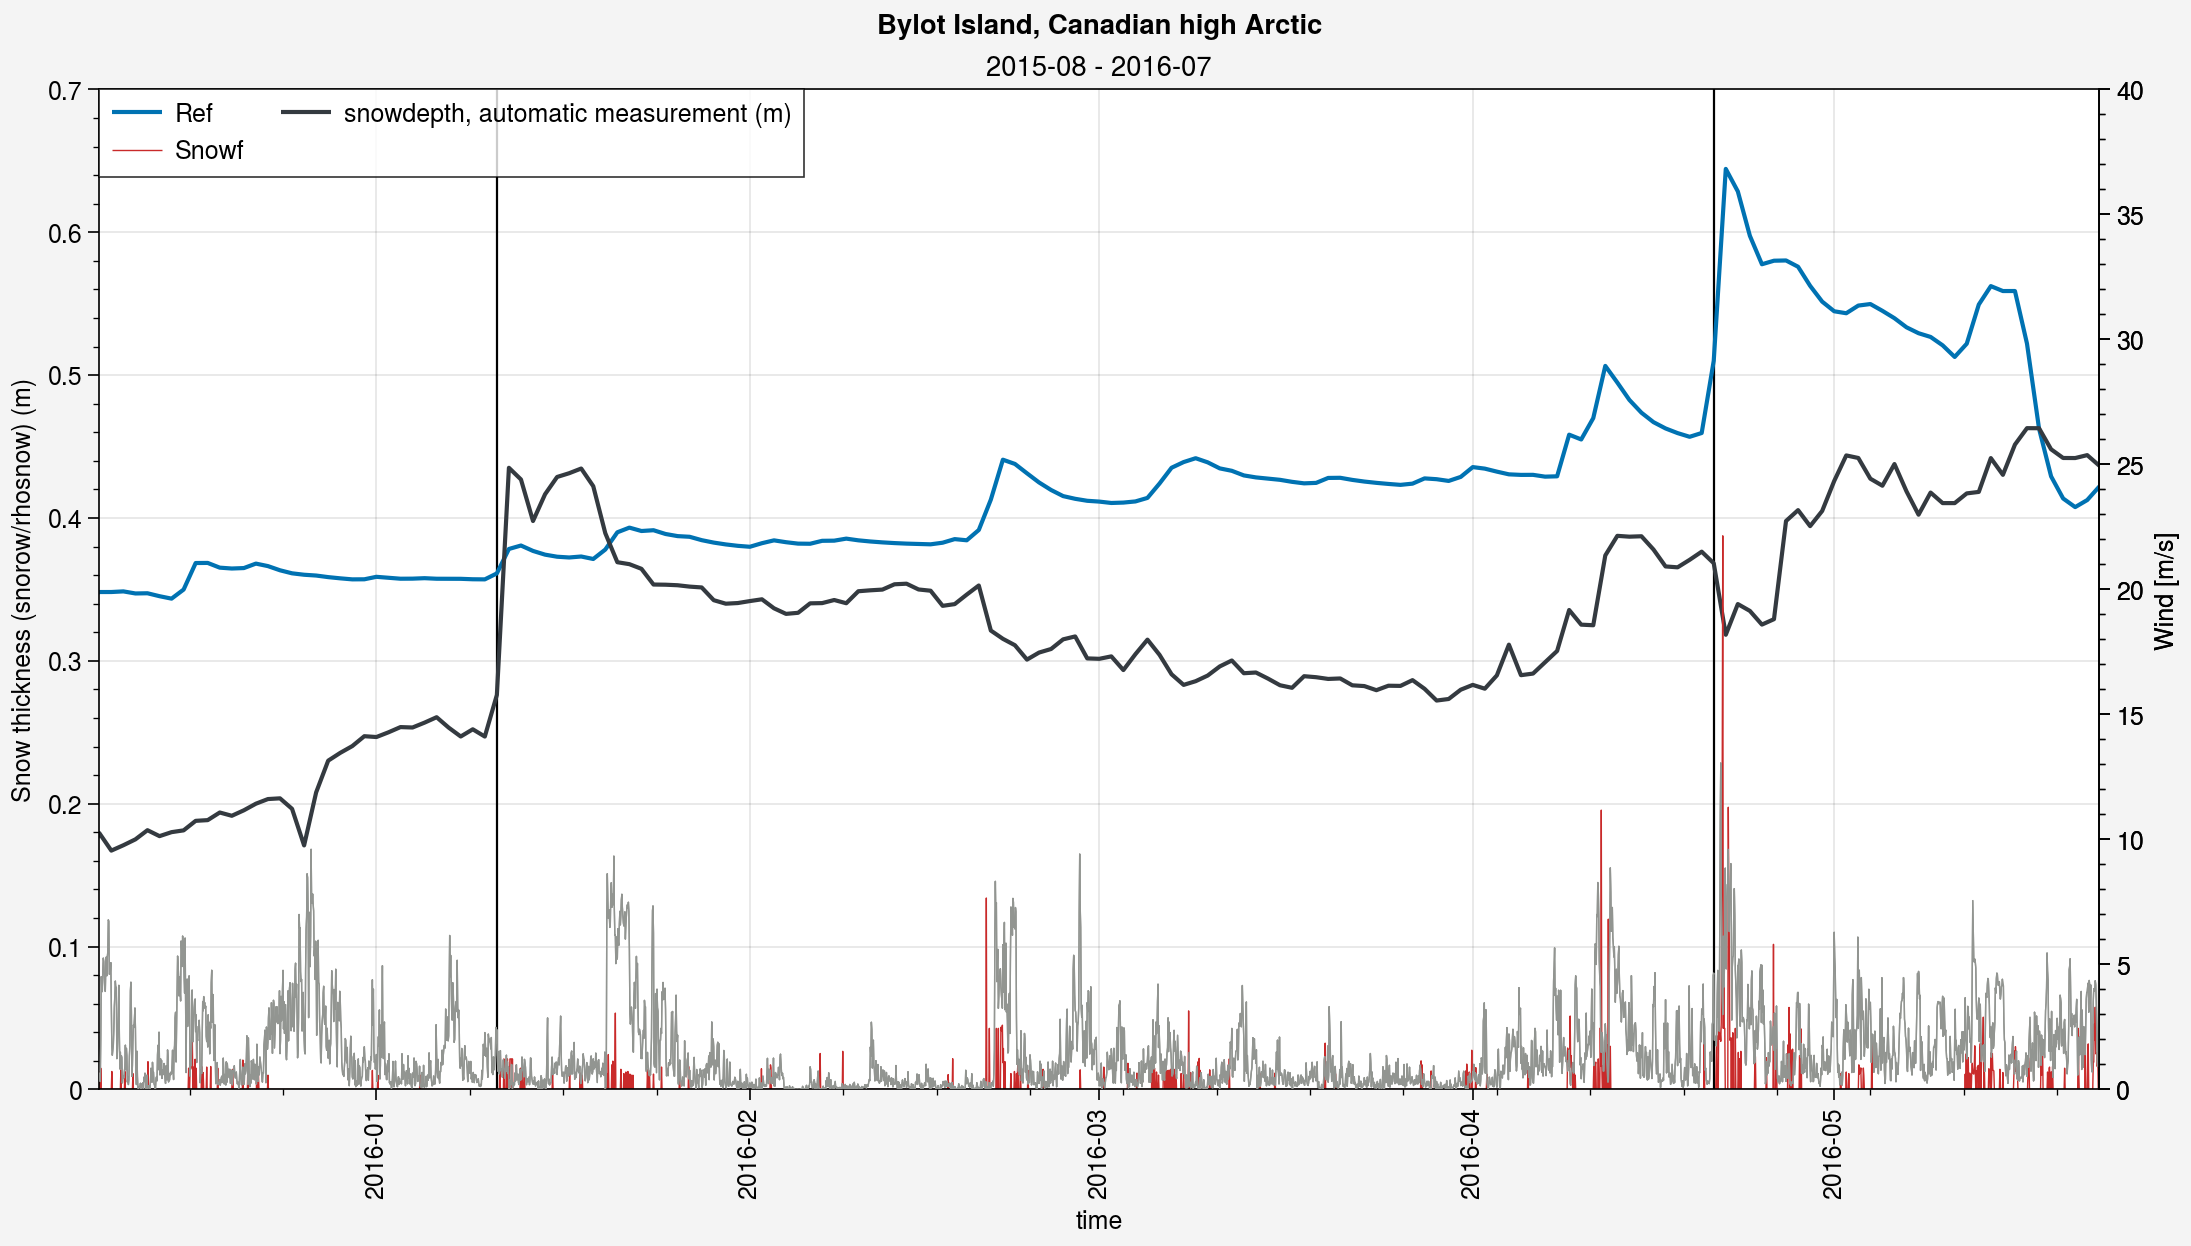

In [90]:
%matplotlib inline

color_obs = 'gray8'

fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=2, refwidth=10)

period=slice('2015-08','2016-07')

# Simus
# for ds_d, label in zip(ds_d_list, labels):
axs[0].plot(ds_d_list[1].snd.sel(time=period), label='Ref')

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), color=color_obs)
axs[0].plot(forcing.Snowf.sel(time=period)*360, color='red9', lw=0.5)

ox = axs[0].alty(label='Wind [m/s]')
ox.plot(forcing.Wind.sel(time=period), color='gray', lw=0.5)
ox.format(ylim=(0, 40))

# axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

# for i in range(ds_d_obs.snd_auto.sel(time=period).time.size-1):
#     a = (ds_d.snd.sel(time=period)[i+1] - ds_d.snd.sel(time=period)[i]).values.item(0)
#     b = (ds_d_obs.snd_auto.sel(time=period)[i+1] - ds_d_obs.snd_auto.sel(time=period)[i]).values.item(0)
#     # print('a = '+str(a)+ ' / b = '+str(b))
#     if (a < 0.1) & (b > 0.1):
axs[0].vlines(ds_d.snd.sel(time=period)[74].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[163].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[264].time, 0.7, color='k', lw=0.8)

# Veg
# axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

axs[0].legend(loc='ul', ncols=2)
axs[0].format(title=period.start+' - '+period.stop,
            xlim=(ds_d.snd.sel(time=period)[130].time, ds_d.snd.sel(time=period)[-70].time),
             )

fig.suptitle(site_longname)
# fig.save('bylot_snd_2016_ex_zoom_wind.pdf')

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

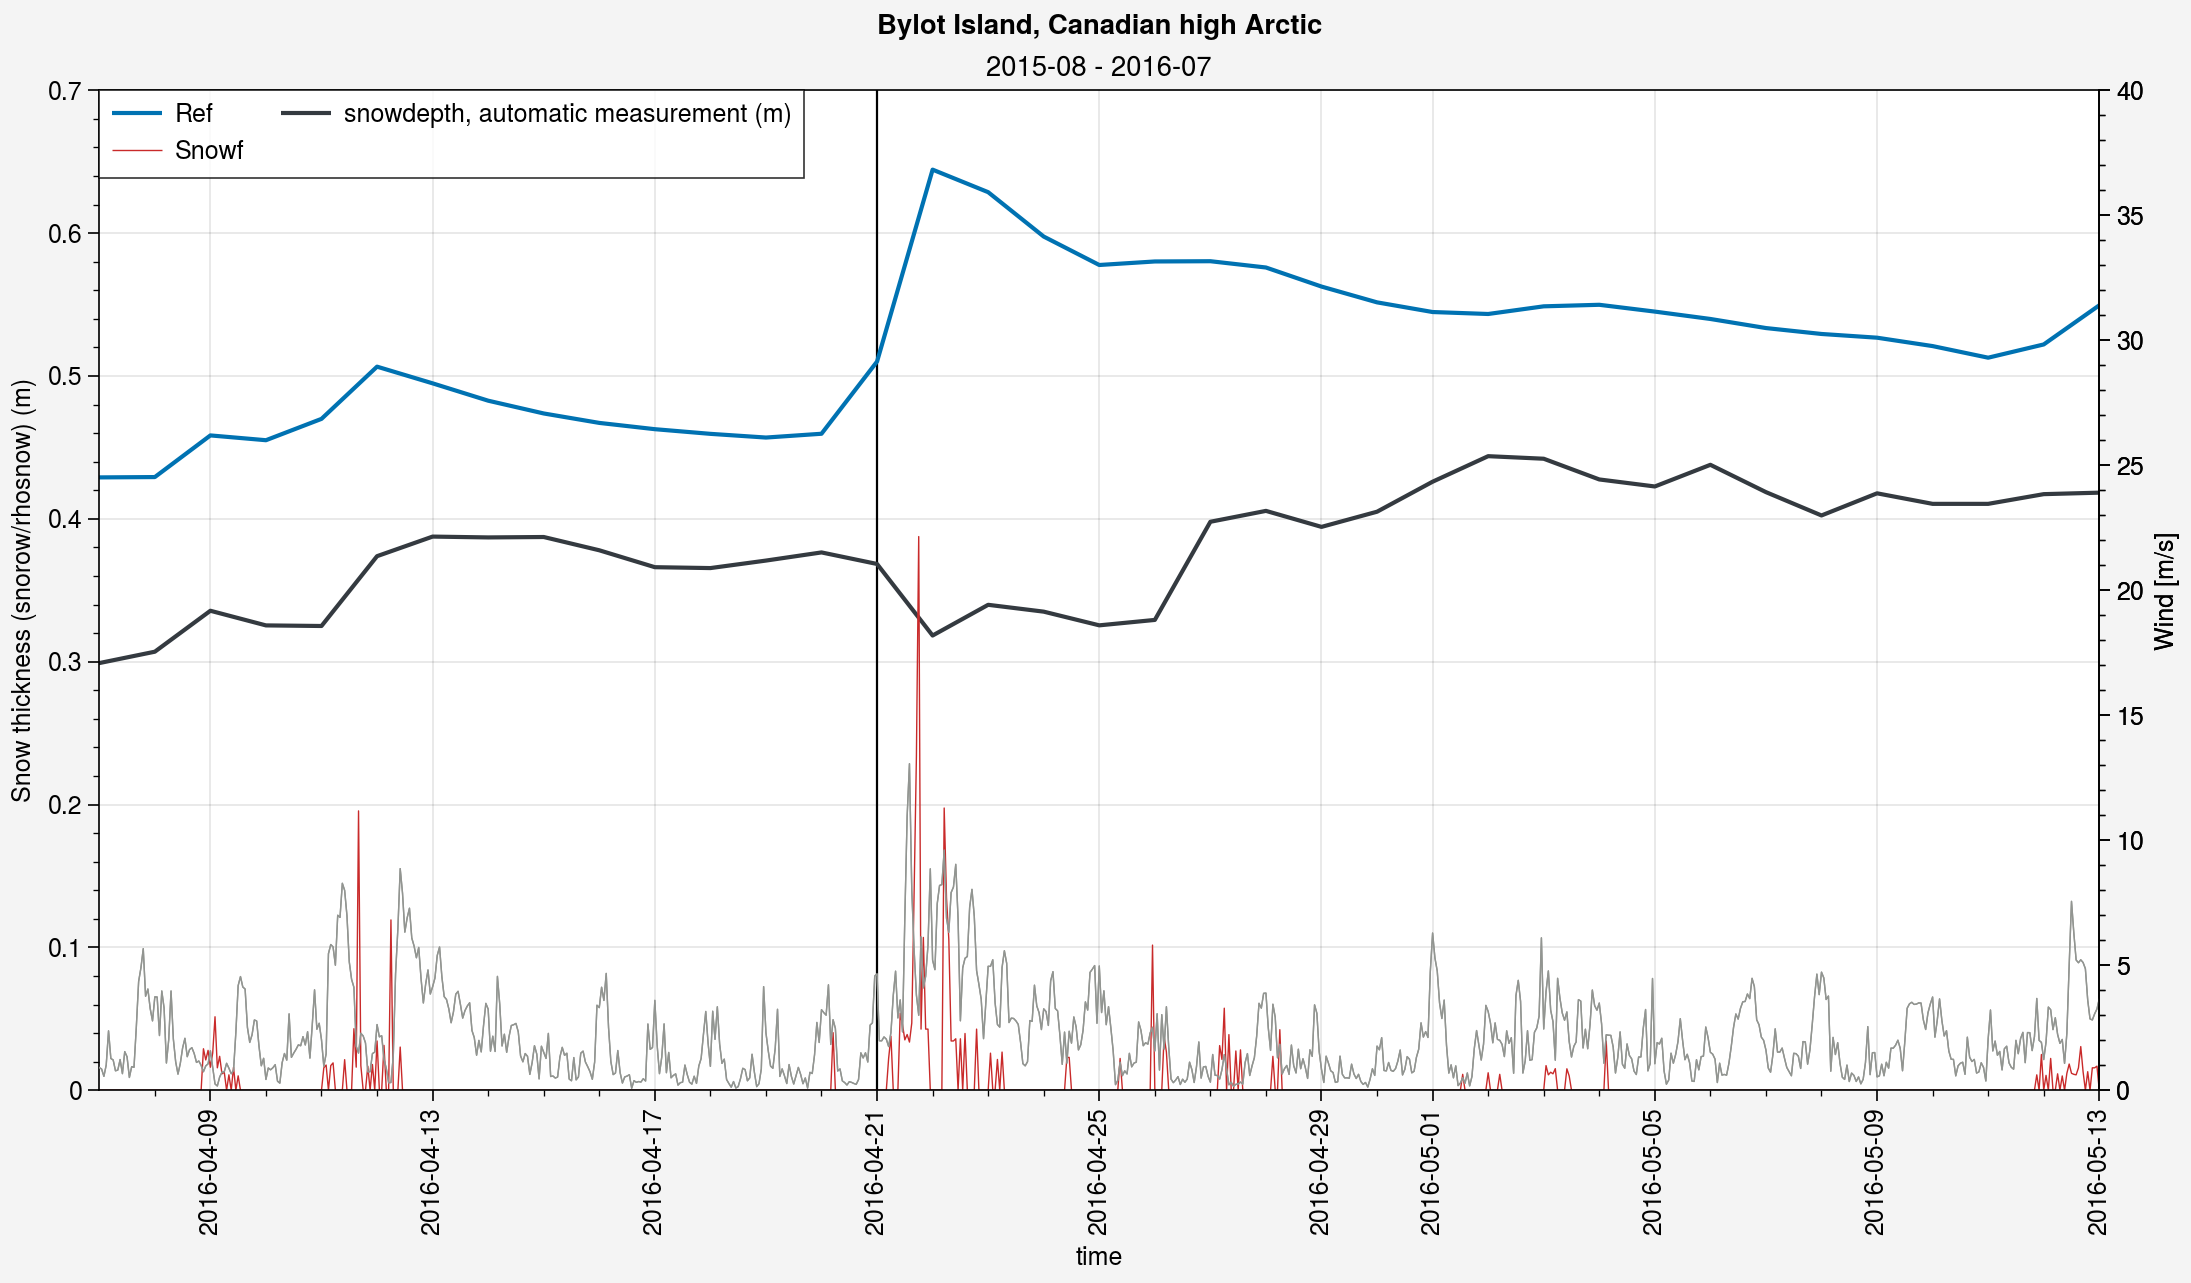

In [89]:
%matplotlib inline

color_obs = 'gray8'

fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=2, refwidth=10)

period=slice('2015-08','2016-07')

# Simus
# for ds_d, label in zip(ds_d_list, labels):
axs[0].plot(ds_d_list[1].snd.sel(time=period), label='Ref')

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), color=color_obs)
axs[0].plot(forcing.Snowf.sel(time=period)*360, color='red9', lw=0.5)

ox = axs[0].alty(label='Wind [m/s]')
ox.plot(forcing.Wind.sel(time=period), color='gray', lw=0.5)
ox.format(ylim=(0, 40))

# axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

# for i in range(ds_d_obs.snd_auto.sel(time=period).time.size-1):
#     a = (ds_d.snd.sel(time=period)[i+1] - ds_d.snd.sel(time=period)[i]).values.item(0)
#     b = (ds_d_obs.snd_auto.sel(time=period)[i+1] - ds_d_obs.snd_auto.sel(time=period)[i]).values.item(0)
#     # print('a = '+str(a)+ ' / b = '+str(b))
#     if (a < 0.1) & (b > 0.1):
axs[0].vlines(ds_d.snd.sel(time=period)[74].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[163].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[264].time, 0.7, color='k', lw=0.8)

# Veg
# axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

axs[0].legend(loc='ul', ncols=2)
axs[0].format(title=period.start+' - '+period.stop,
            xlim=(ds_d.snd.sel(time=period)[250].time, ds_d.snd.sel(time=period)[-80].time),
             )

fig.suptitle(site_longname)
# fig.save('bylot_snd_2016_ex.pdf')

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

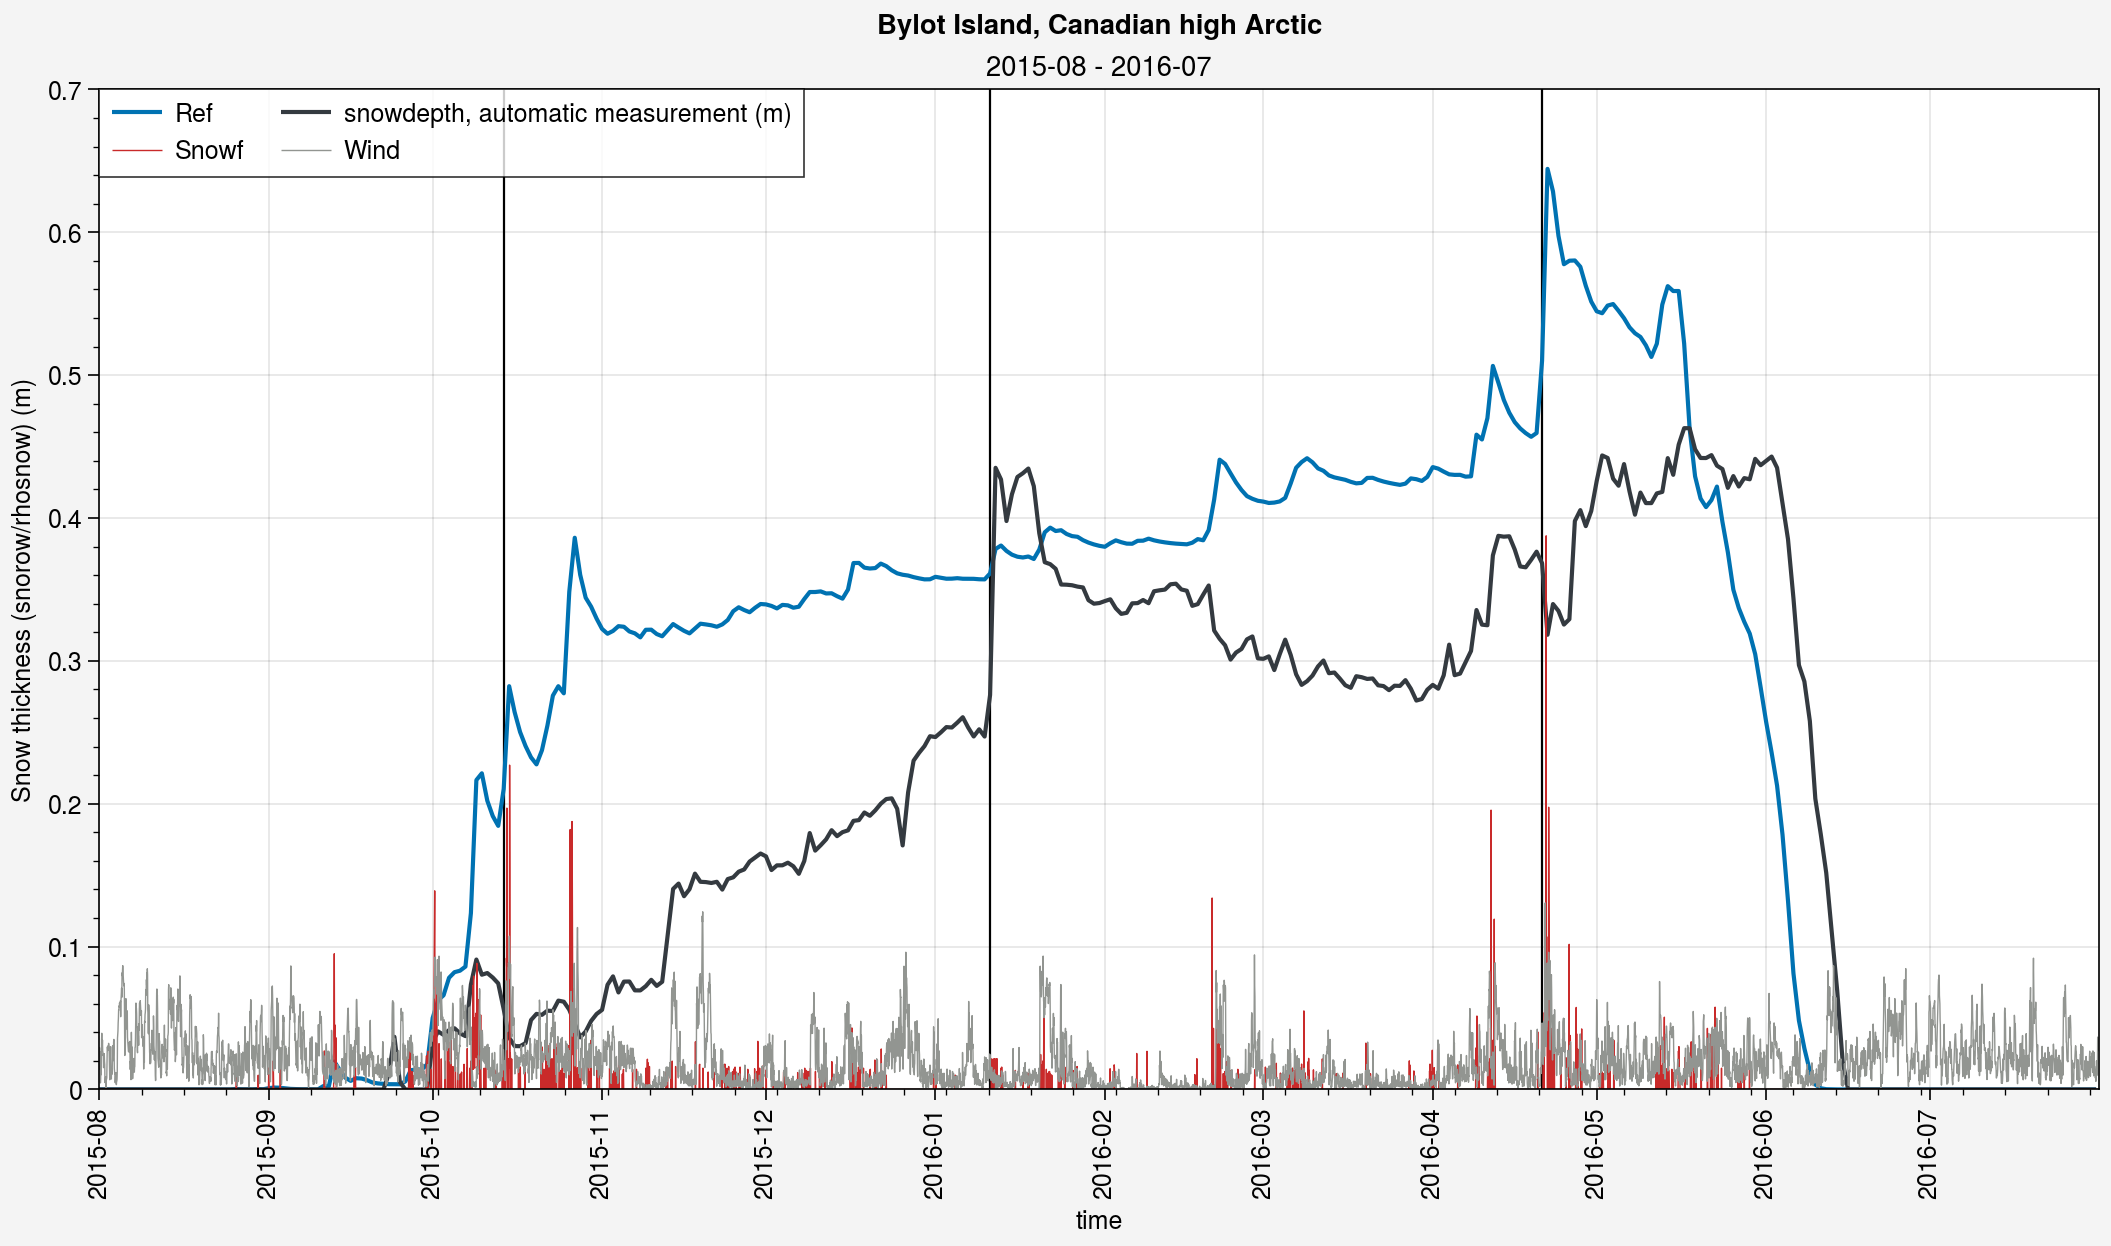

In [58]:
%matplotlib inline

color_obs = 'gray8'

fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=2, refwidth=10)

period=slice('2015-08','2016-07')

# Simus
# for ds_d, label in zip(ds_d_list, labels):
axs[0].plot(ds_d_list[1].snd.sel(time=period), label='Ref')

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
#     np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_obs.snd_auto.sel(time=period), color=color_obs)
axs[0].plot(forcing.Snowf.sel(time=period)*360, color='red9', lw=0.5)
axs[0].plot(forcing.Wind.sel(time=period)*1e-2, color='gray', lw=0.5)

# axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

# for i in range(ds_d_obs.snd_auto.sel(time=period).time.size-1):
#     a = (ds_d.snd.sel(time=period)[i+1] - ds_d.snd.sel(time=period)[i]).values.item(0)
#     b = (ds_d_obs.snd_auto.sel(time=period)[i+1] - ds_d_obs.snd_auto.sel(time=period)[i]).values.item(0)
#     # print('a = '+str(a)+ ' / b = '+str(b))
#     if (a < 0.1) & (b > 0.1):
axs[0].vlines(ds_d.snd.sel(time=period)[74].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[163].time, 0.7, color='k', lw=0.8)
axs[0].vlines(ds_d.snd.sel(time=period)[264].time, 0.7, color='k', lw=0.8)

# Veg
# axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

axs[0].legend(loc='ul', ncols=2)
axs[0].format(title=period.start+' - '+period.stop)

fig.suptitle(site_longname)
# fig.save('bylot_snd_2016_ex.pdf')

There is a Geonor 200 precipitation gauge with a single alter shield at the CAMP site, 1.7 km from our TUNDRA site, but most of the time, it did not function properly. We therefore relied mostly on data from the ECCC Geonor gauges at Pond Inlet, 84.1 km to the southeast, and Cape Liverpool, 79.5 km to the northeast (Fig. 1).

#### Domine et al. ([2021](https://essd.copernicus.org/articles/13/4331/2021/)): Meteorological, snow and soil data (2013–2019) from a herb tundra permafrost site at Bylot Island, Canadian high Arctic, for driving and testing snow and land surface models

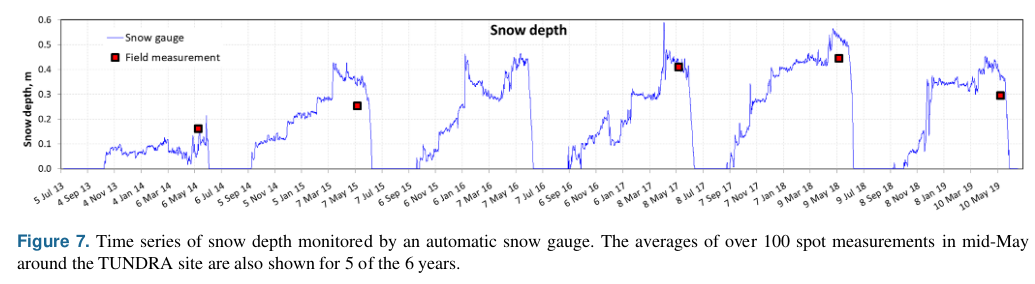

Note: we loose first and last year because CLASSIC require full years. We could duplicate the forcing at the beginning and the end to encompass the full observation period.

#### Barrare et al. ([2017](https://gmd.copernicus.org/articles/10/3461/2017/))): Evaluating the performance of coupled snow–soil models in SURFEXv8 to simulate the permafrost thermal regime at a high Arctic site

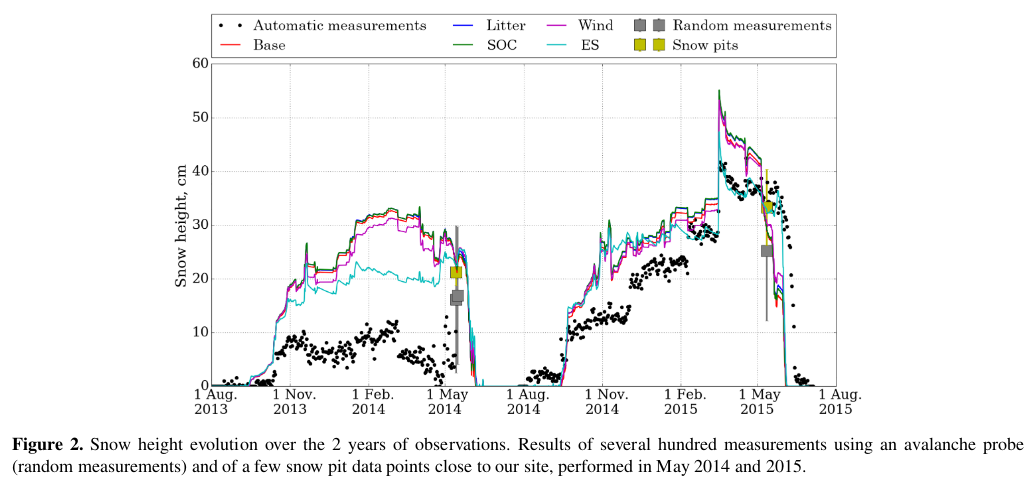

Barrare et al. ([2017](https://gmd.copernicus.org/articles/10/3461/2017/))): "With no reliable precipitation gauge to evaluate the local variability, we consider the precipitation data as the highest uncertainty source of all the forcing data. Preliminary results indicated that an accurate snow height was critical to simulate correctly the soil thermal regime. Hence, we arbitrarily changed the ERAi precipitation data for Crocus to match the observed snow height at snow pits dug in the immediate vicinity of BylSta, which was achieved after reducing the solid precipitation rate by 30 % in winter 2013–2014. Neither liquid precipitations nor snowfall were modified for the winter 2014–2015."

"To test whether the inexact melt onset date simulated was caused by the lack of SZA consideration, we briefly tested Crocus coupled to TARTES, which includes treatment of SZA. With TARTES, the melt onset date was accurately simulated, which leads us to suggest that not accounting for SZA is the main cause of the inadequate melt onset date simulation."

### SWE

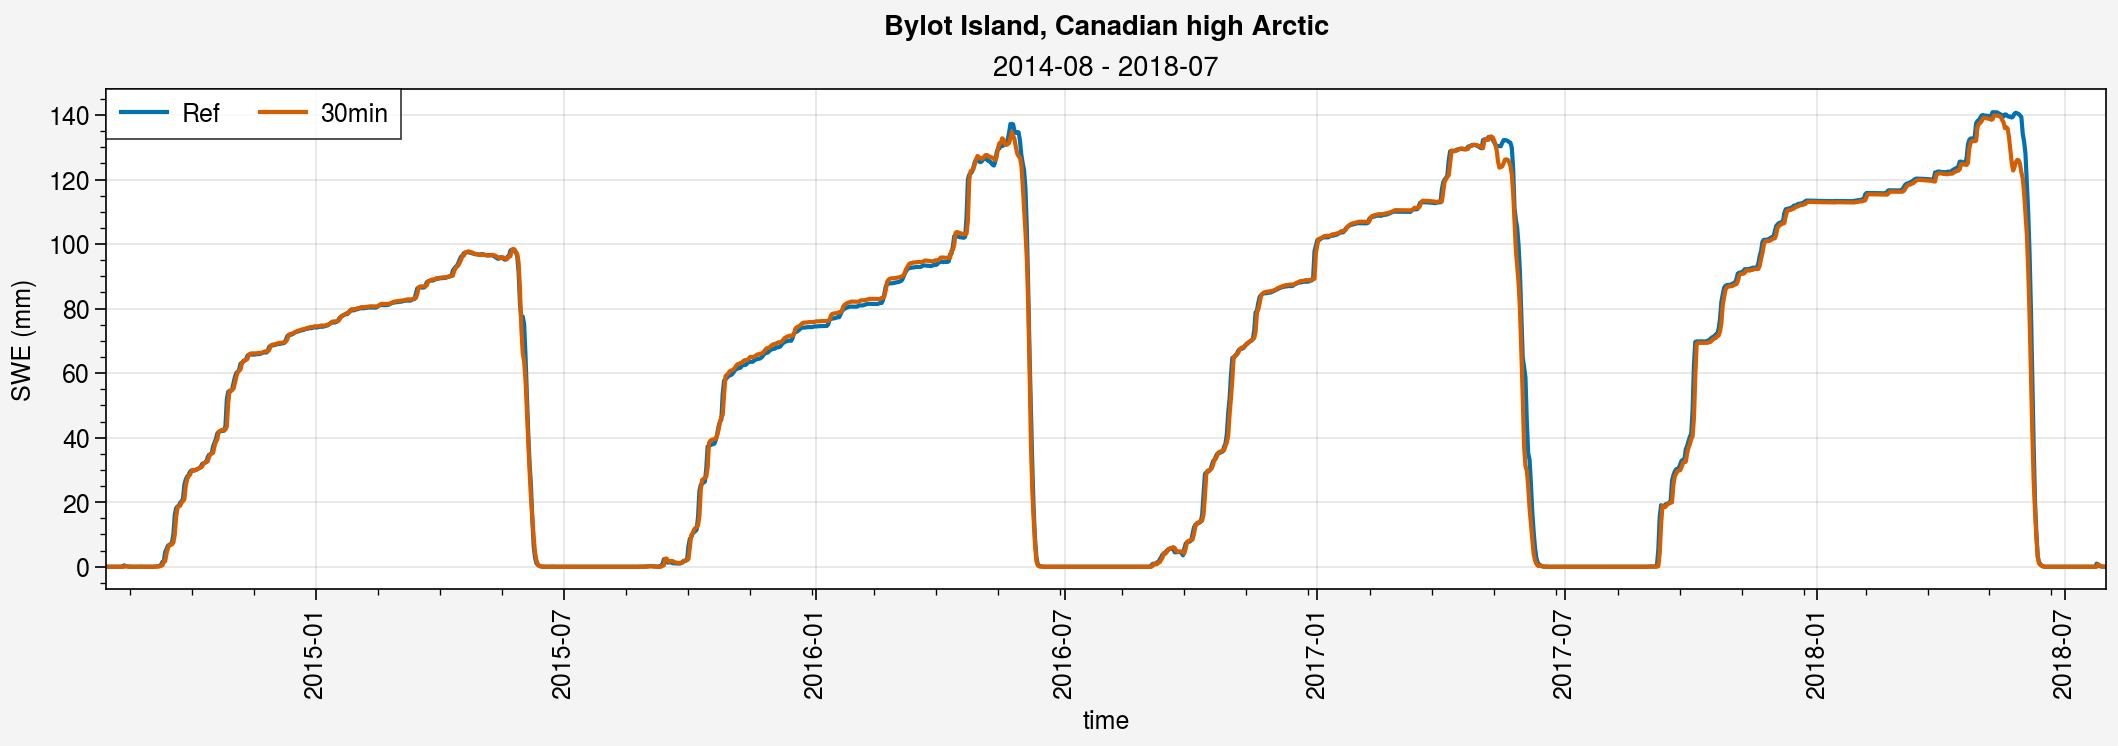

In [33]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


In [34]:
path_forcing = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
forcing = xr.open_dataset(path_forcing+'/met_insitu_'+site+'_2013_2019.nc')

In [35]:
path_met = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
df_met = pd.read_csv(path_met+'/Bylot/Bylot_driving_dataV2.csv', parse_dates=['DATE'], dayfirst=True, index_col=['DATE'])
ds_met = df_met.to_xarray()
df_met

WindSpeed m/s  0=Data; 1=Gap-filled  Air Temp. °C  \
DATE                                                                     
2013-07-11 09:00:00          1.530                     0      6.819953   
2013-07-11 10:00:00          1.405                     0      6.957644   
2013-07-11 11:00:00          2.021                     0      8.925269   
2013-07-11 12:00:00          2.559                     0     10.422386   
2013-07-11 13:00:00          2.749                     0      8.218802   
...                            ...                   ...           ...   
2019-06-25 06:00:00          0.713                     0     11.119000   
2019-06-25 07:00:00          0.908                     0     10.895000   
2019-06-25 08:00:00          2.065                     0     10.744000   
2019-06-25 09:00:00          1.450                     0     10.433000   
2019-06-25 10:00:00          1.135                     0      9.186000   

                     Relative Humidity  Specific humidity g/kg  \
DATE                                                             
2013-07-11 09:00:00              91.18                  5.6257   
2013-07-11 10:00:00              89.27                  5.5593   
2013-07-11 11:00:00              90.20                  6.4263   
2013-07-11 12:00:00              89.57                  7.0594   
2013-07-11 13:00:00              88.42                  6.0033   
...                                ...                     ...   
2019-06-25 06:00:00              63.97                  5.2158   
2019-06-25 07:00:00              64.35                  5.1667   
2019-06-25 08:00:00              62.69                  4.9798   
2019-06-25 09:00:00              63.68                  4.9524   
2019-06-25 10:00:00              61.90                  4.4241   

                     Long Wave Downwell. CNR4 W m-2   0=CNR4; 1=Modified ERA  \
DATE                                                                           
2013-07-11 09:00:00                         308.859                        0   
2013-07-11 10:00:00                         299.669                        0   
2013-07-11 11:00:00                         289.596                        0   
2013-07-11 12:00:00                         280.483                        0   
2013-07-11 13:00:00                         283.789                        0   
...                                             ...                      ...   
2019-06-25 06:00:00                         245.120                        0   
2019-06-25 07:00:00                         259.830                        0   
2019-06-25 08:00:00                         251.450                        0   
2019-06-25 09:00:00                         253.880                        0   
2019-06-25 10:00:00                         257.890                        0   

                     Long Wave Downwell. ERA5 W m-2  \
DATE                                                  
2013-07-11 09:00:00                         298.371   
2013-07-11 10:00:00                         289.269   
2013-07-11 11:00:00                         278.748   
2013-07-11 12:00:00                         267.848   
2013-07-11 13:00:00                         257.987   
...                                             ...   
2019-06-25 06:00:00                         206.344   
2019-06-25 07:00:00                         207.897   
2019-06-25 08:00:00                         210.618   
2019-06-25 09:00:00                         213.529   
2019-06-25 10:00:00                         220.462   

                     Short Wave downwell. CNR4 W m-2  0=CNR4; 1=Modified ERA  \
DATE                                                                           
2013-07-11 09:00:00                           250.90                       0   
2013-07-11 10:00:00                           310.49                       0   
2013-07-11 11:00:00                           672.70                       0   
2013-07-11 12:00:00                       

### Albedo

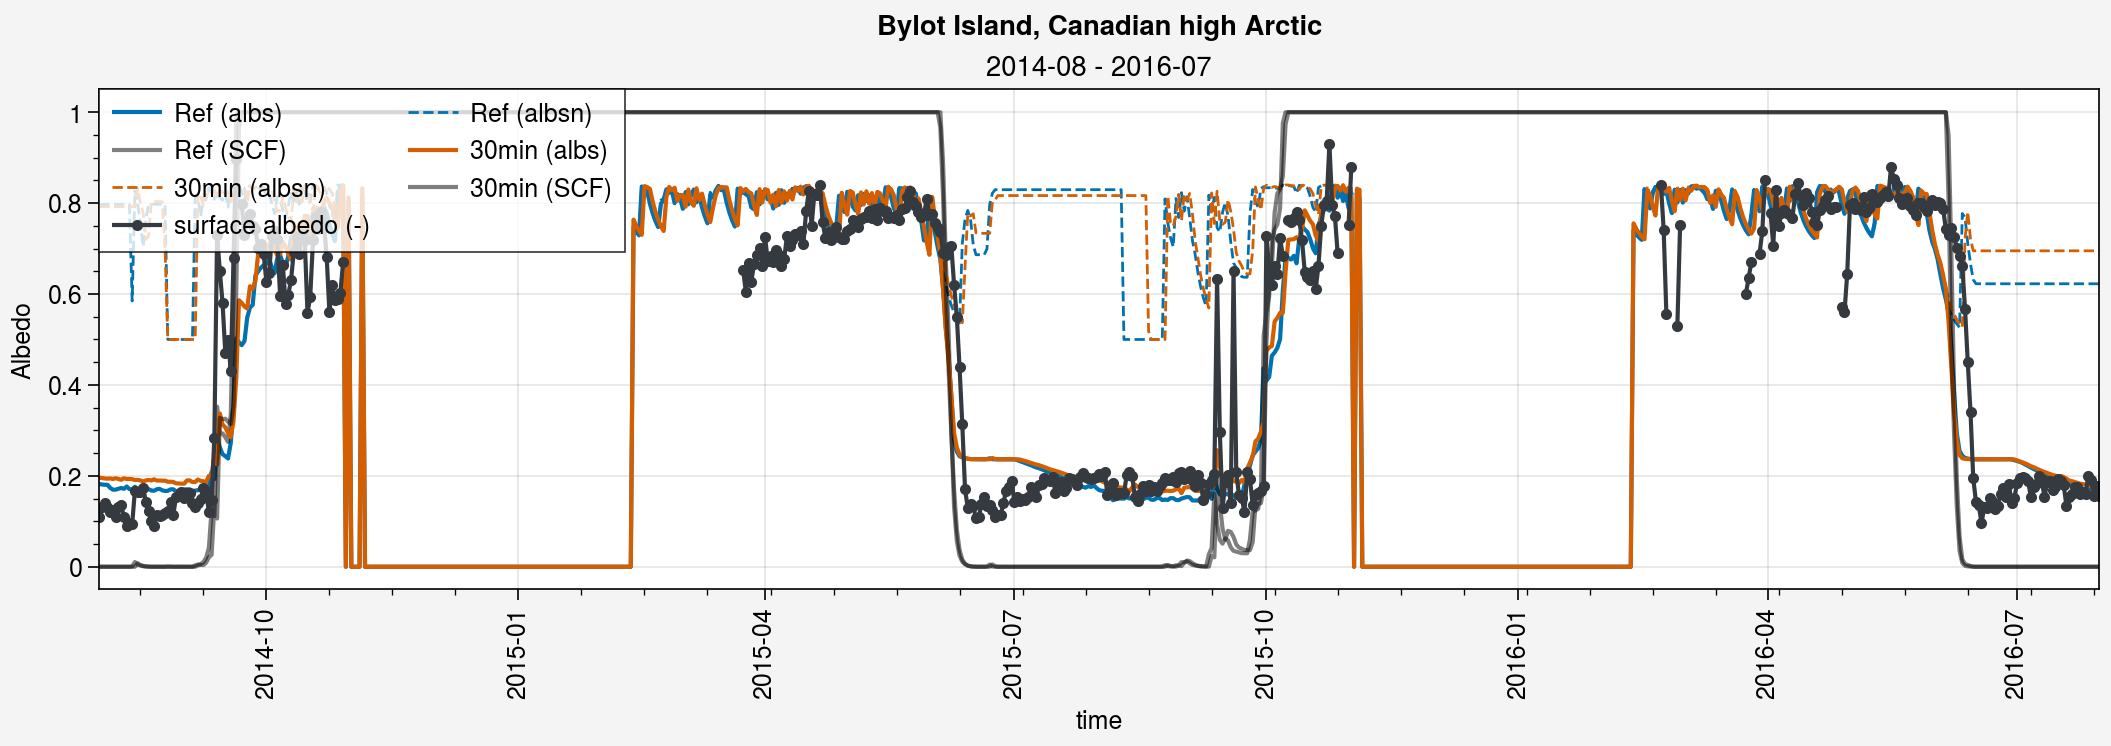

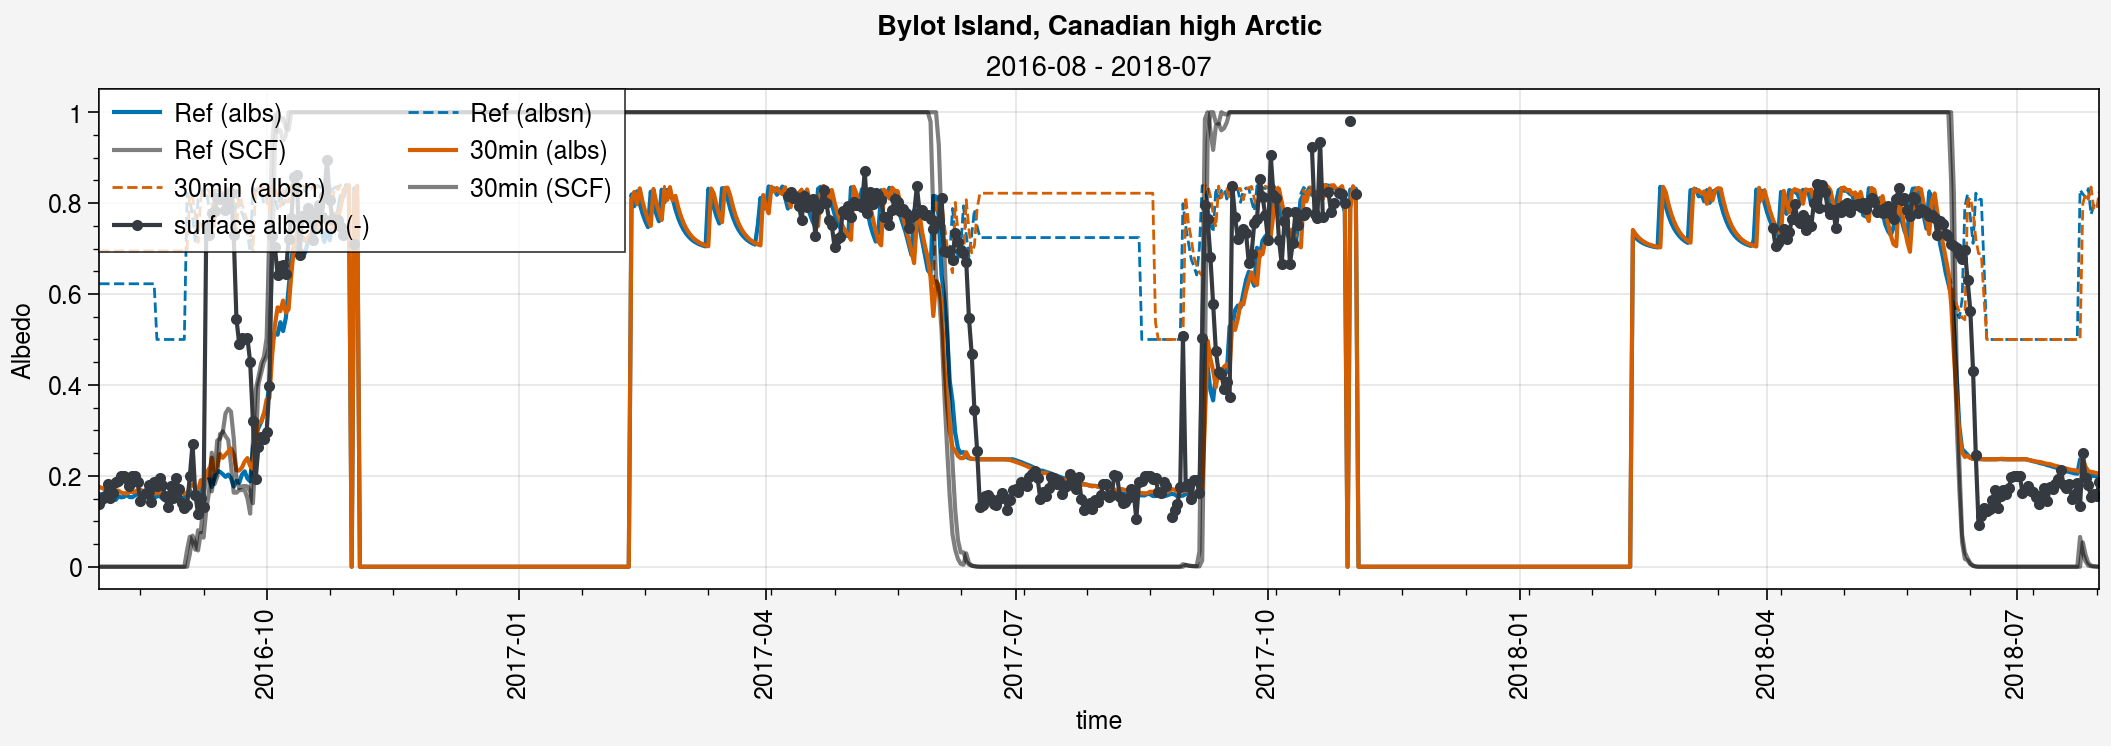

In [38]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1
    
    # Obs
    axs[0].plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
    fig.suptitle(site_longname)


### Surface Temperature

Domine et al. ([2019](https://onlinelibrary.wiley.com/doi/abs/10.1029/2018MS001445)): "**Averaged over a period of several days the surface temperatures are essentially the same**. The amplitude variations are greater in the Alpine snowpack (Figure 8b) because the insulating layer at the top does not allow damping the air temperature variations by heat exchanges with the snowpack. This effect is more important in April and May, when daily temperature variations reach 20 °C, sometimes more. The absolute temperature differences reaches 4.7 °C on 8 February, when the temperature suddenly increases by 15 °C in 5 hr, and the surface temperature of the Alpine snowpack increases more rapidly."

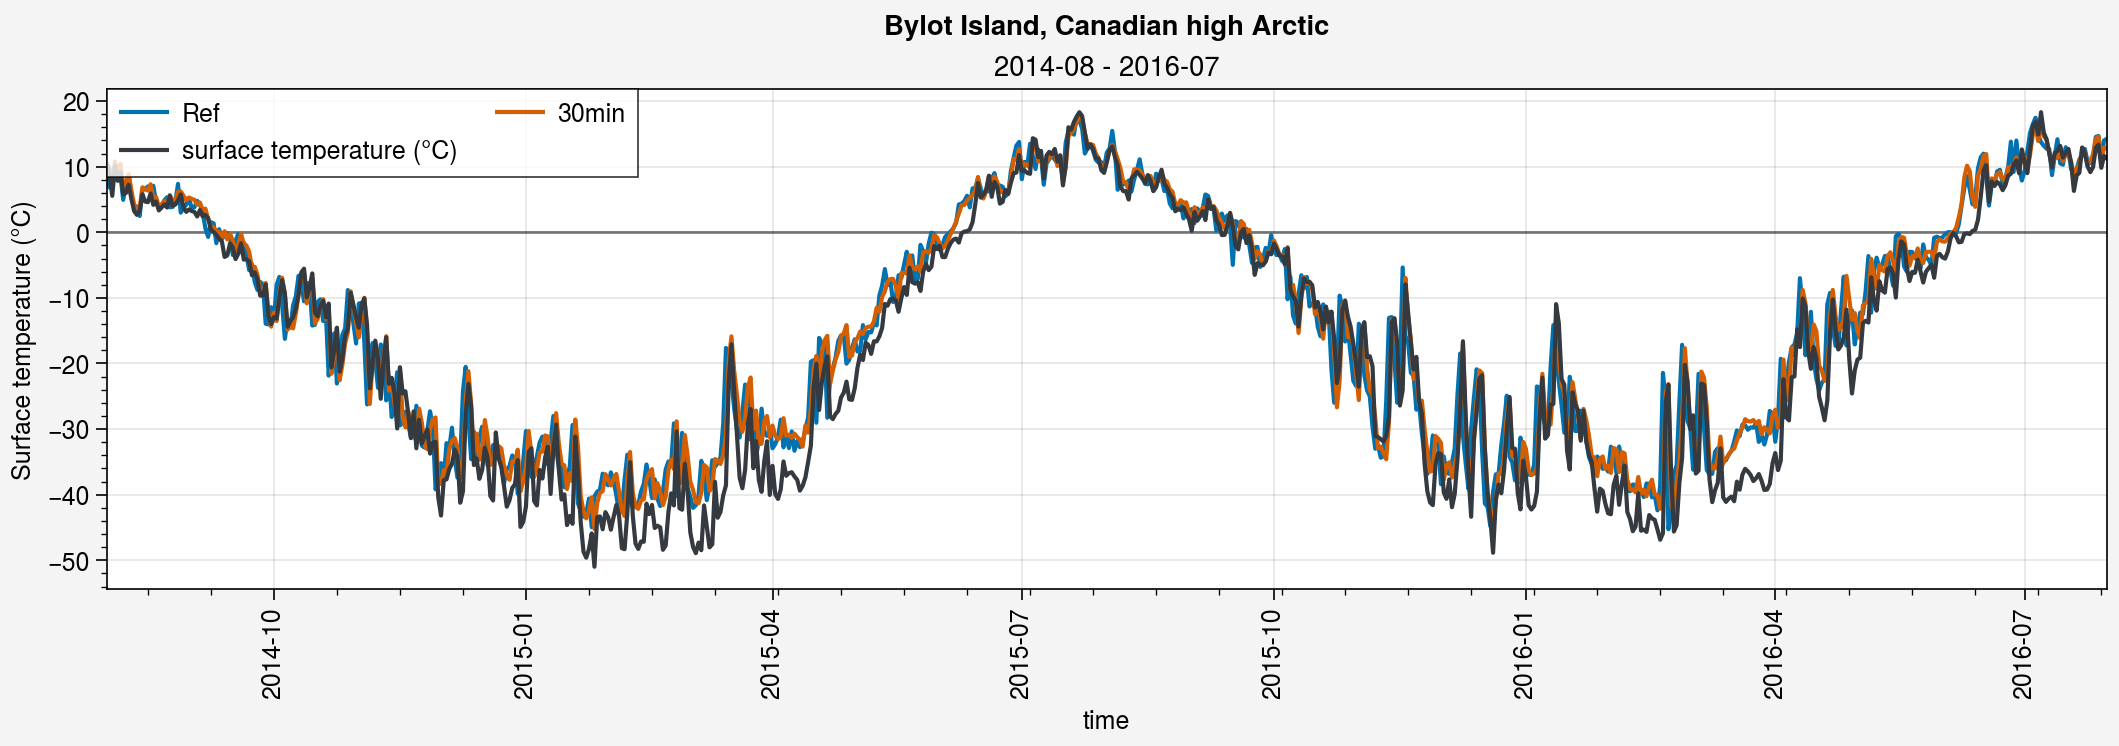

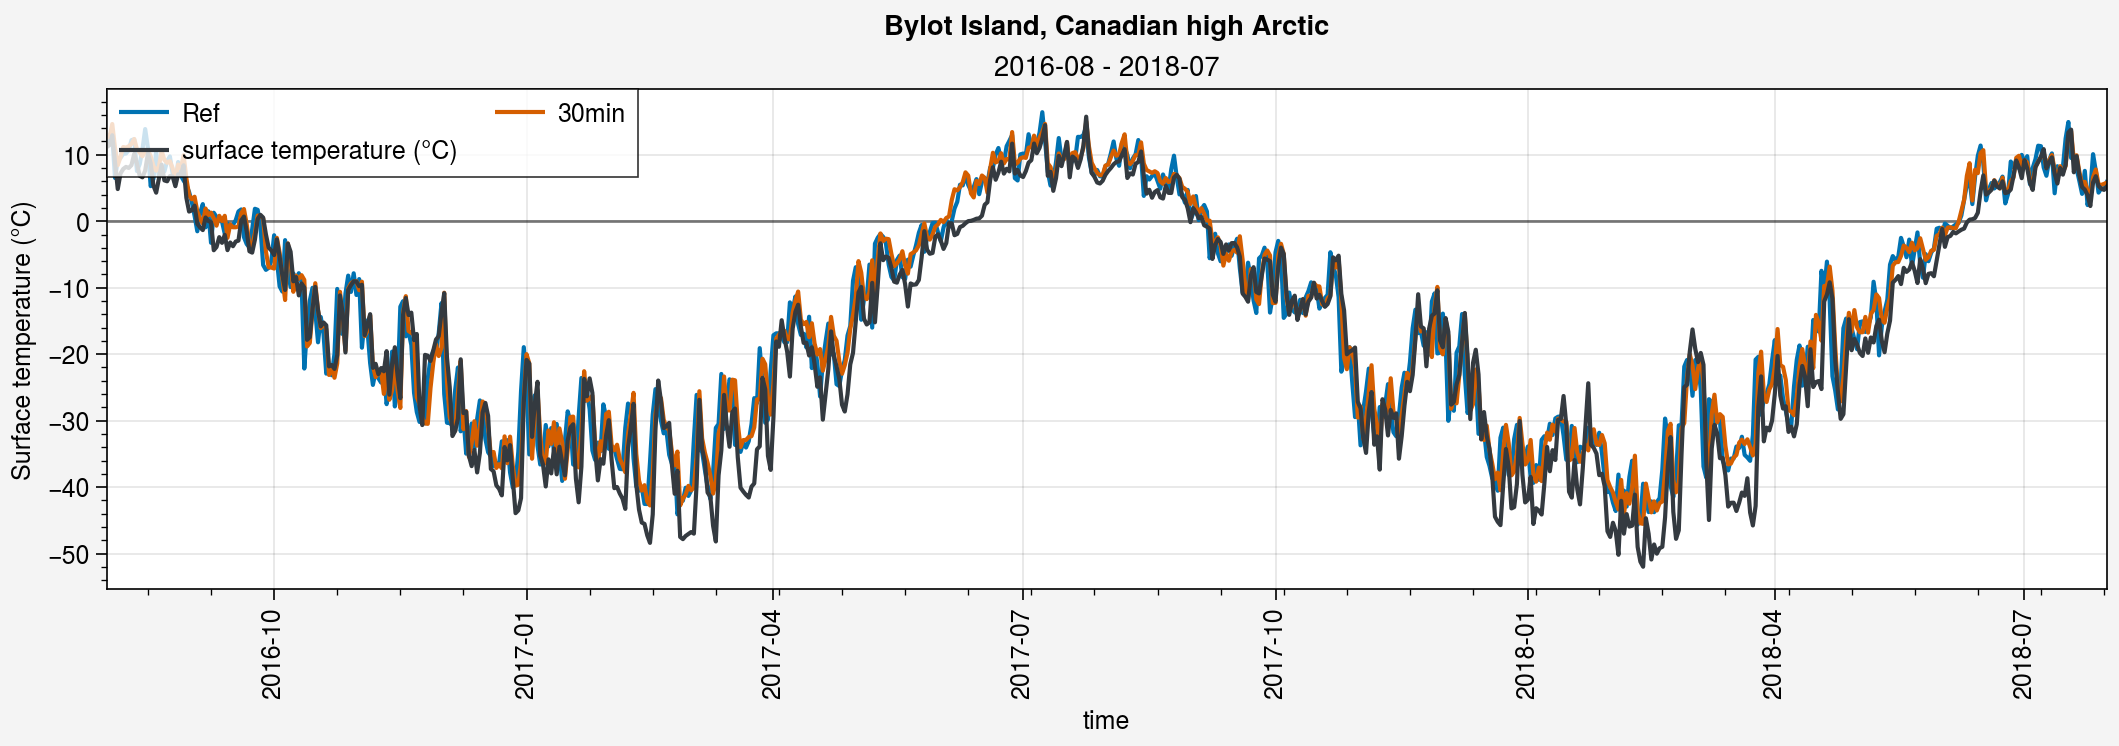

In [39]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)
    
    # Obs
    axs[0].plot(ds_d_obs.ts.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

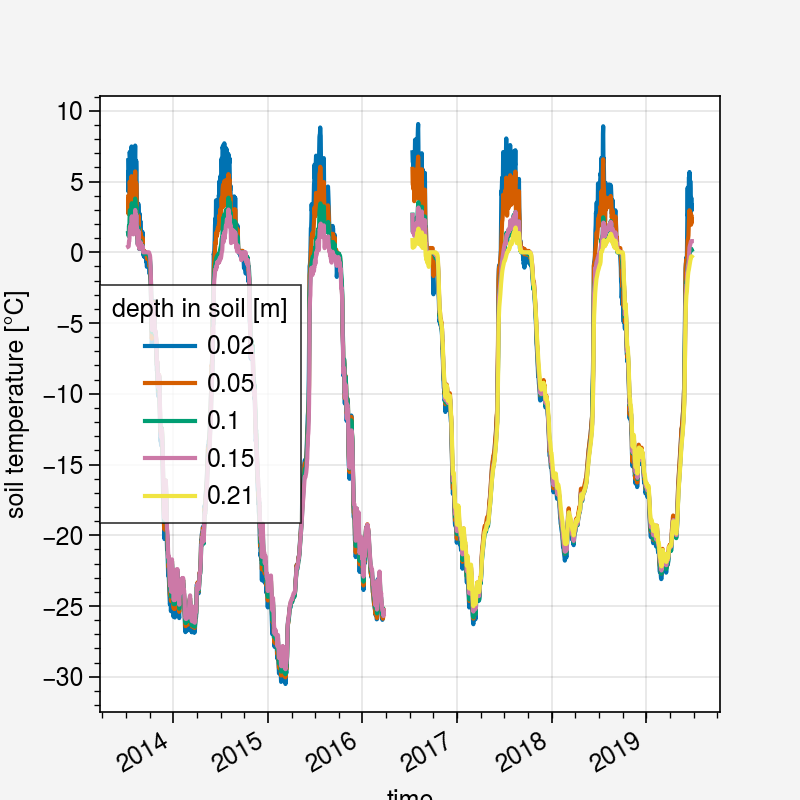

In [41]:
%matplotlib inline
ds_d_obs.tsl.plot(hue='sdepth')

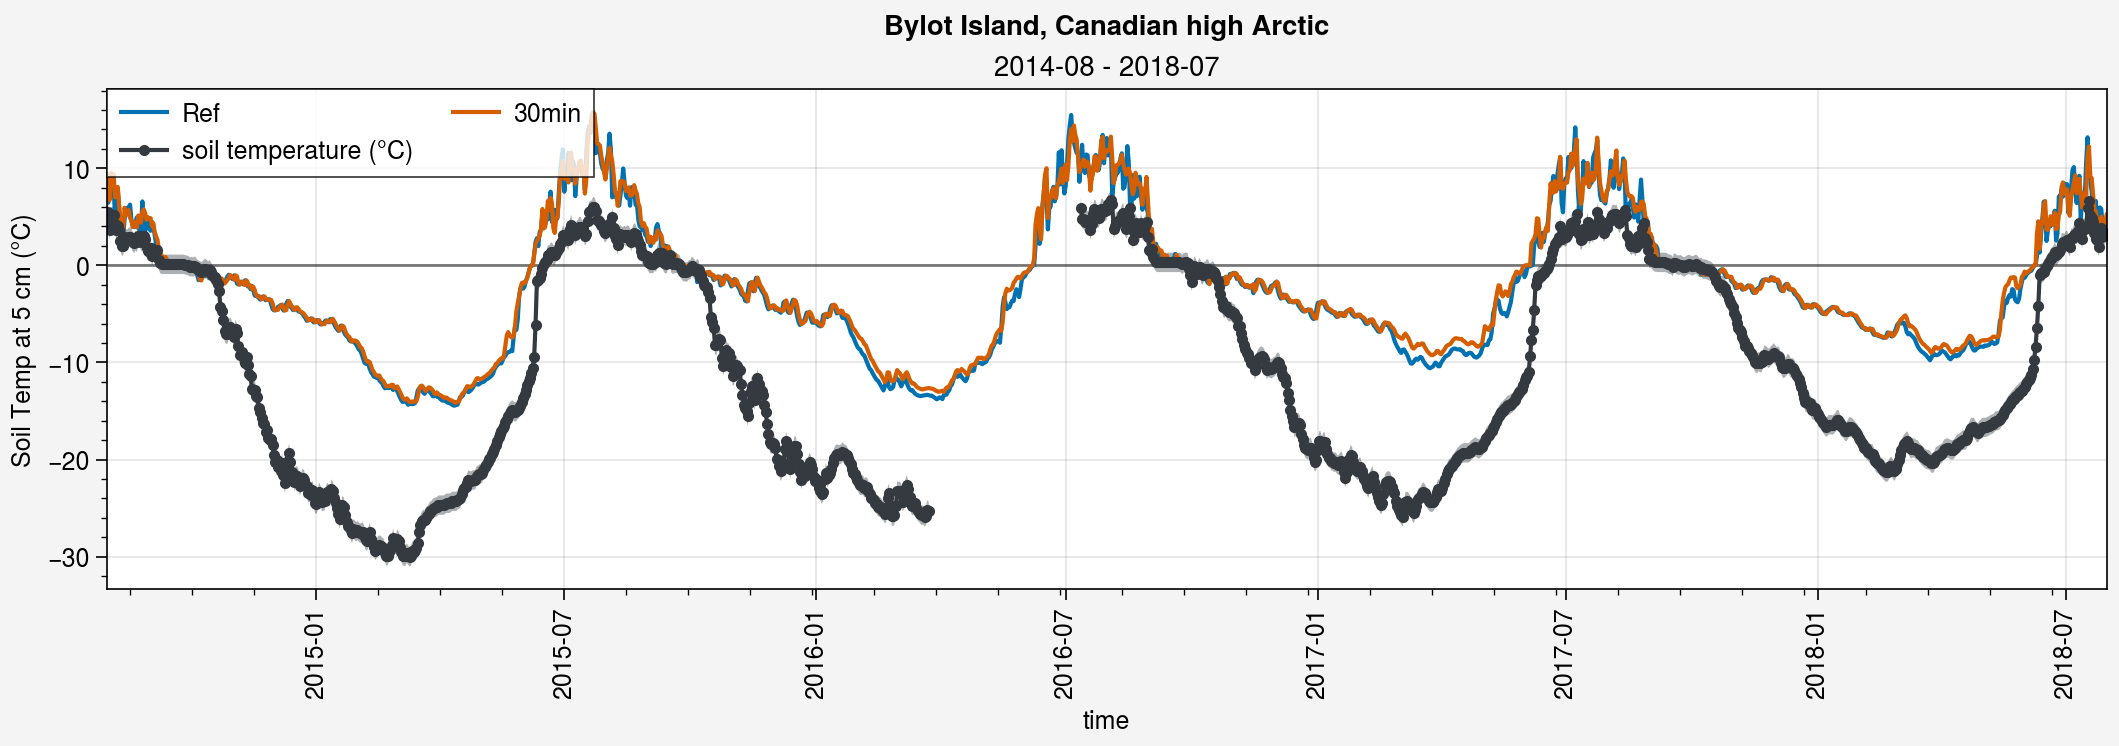

In [42]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth)-273.15, label=label)
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


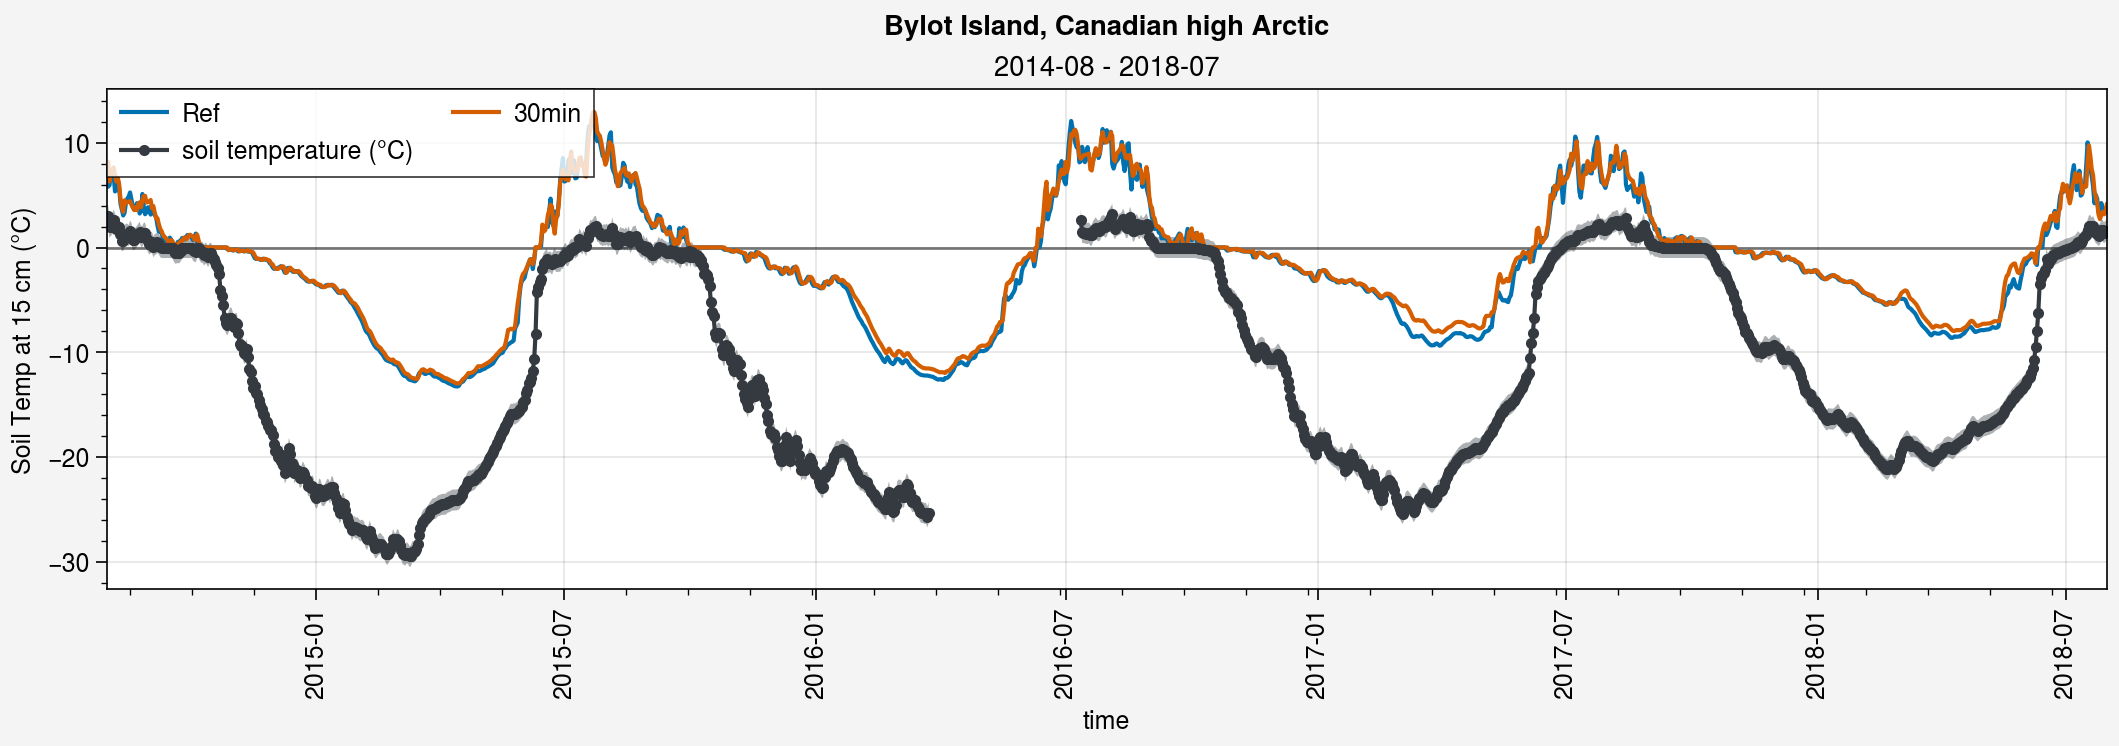

In [43]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


### Snow temperature

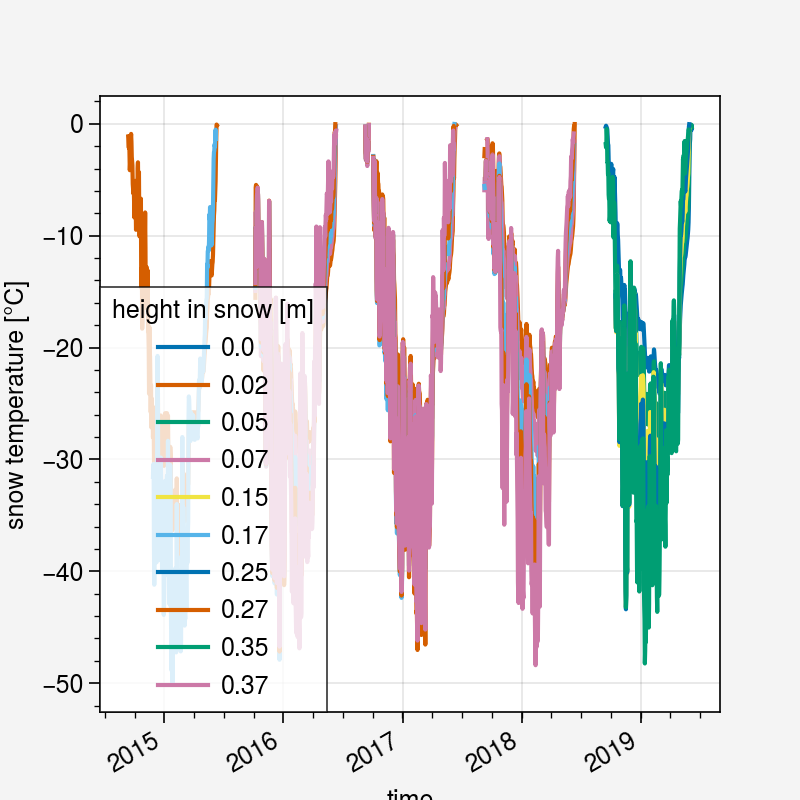

In [44]:
ds_d_obs.tsnl.plot(hue='sheight')

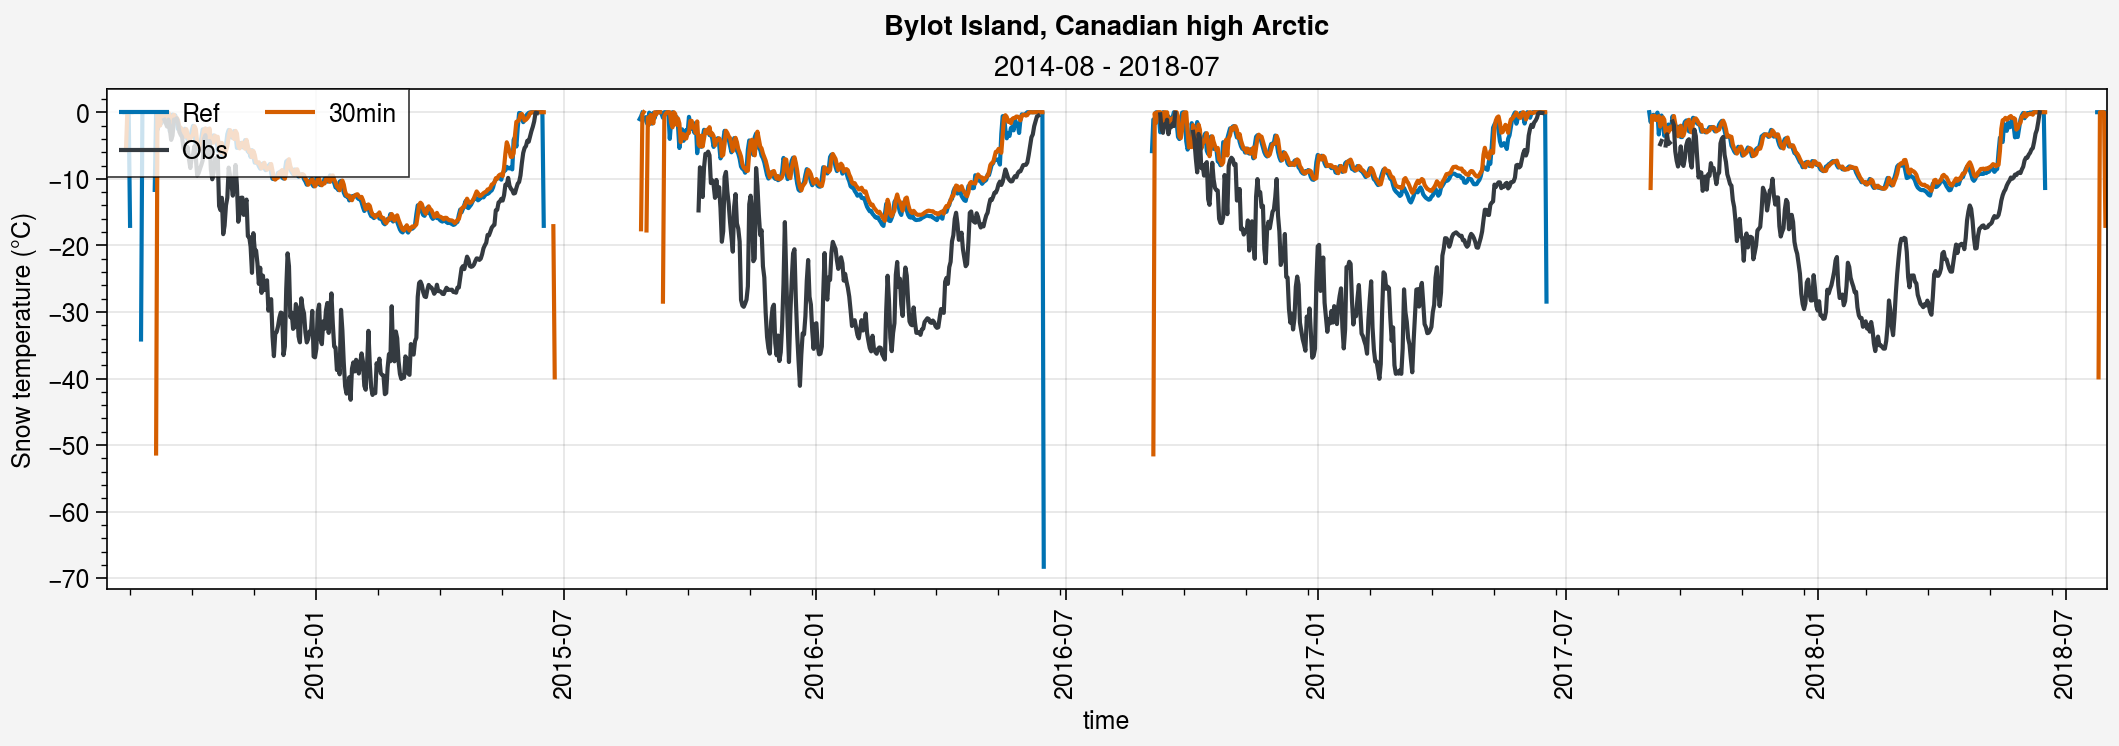

In [45]:
%matplotlib inline
gap = 4
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.tsn.sel(time=period).where(ds_d.tsn > 200)-273.15, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.tsnl.mean('sheight').sel(time=period), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Snow temperature (°C)')
    
    fig.suptitle(site_longname)


### Volumetric water content

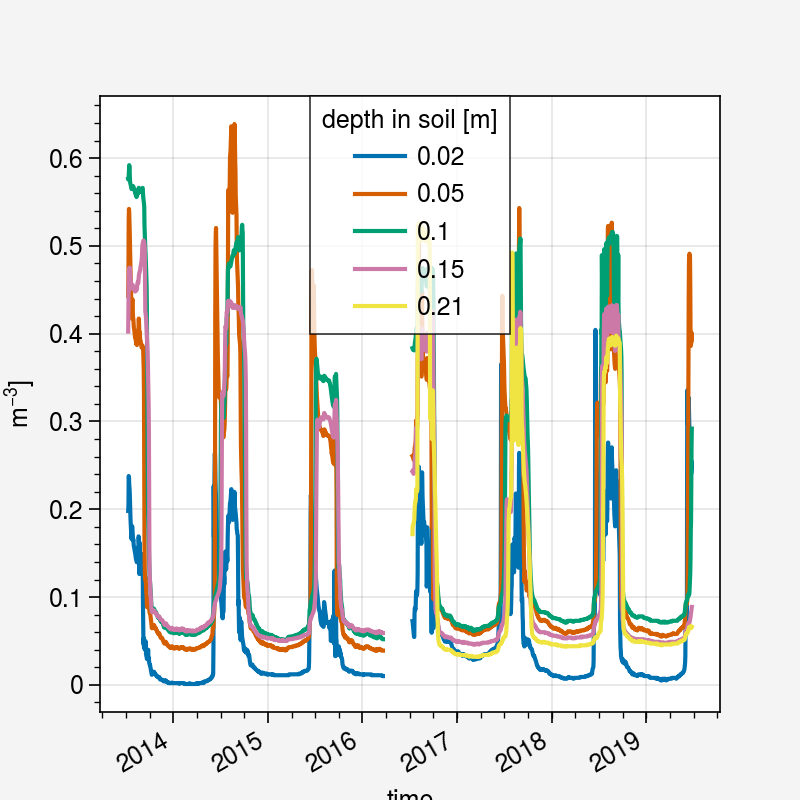

In [46]:
%matplotlib inline
ds_d_obs.mrsll.plot(hue='sdepth')

In [170]:
ds_d.mrsll

<xarray.DataArray 'mrsll' (time: 1826, layer: 20)>
array([[4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       ...,
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2018-12-31
  * layer    (layer) float64 0.05 0.15 0.25 0.35 0.45 ... 4.9 8.9 18.9 41.4 58.9
Attributes:
    long_name:   In each soil layer, the mass of water in liquid phase. Repor...
    units:       kg m$^{-2}$
    nameInCode:  thlqacc_d

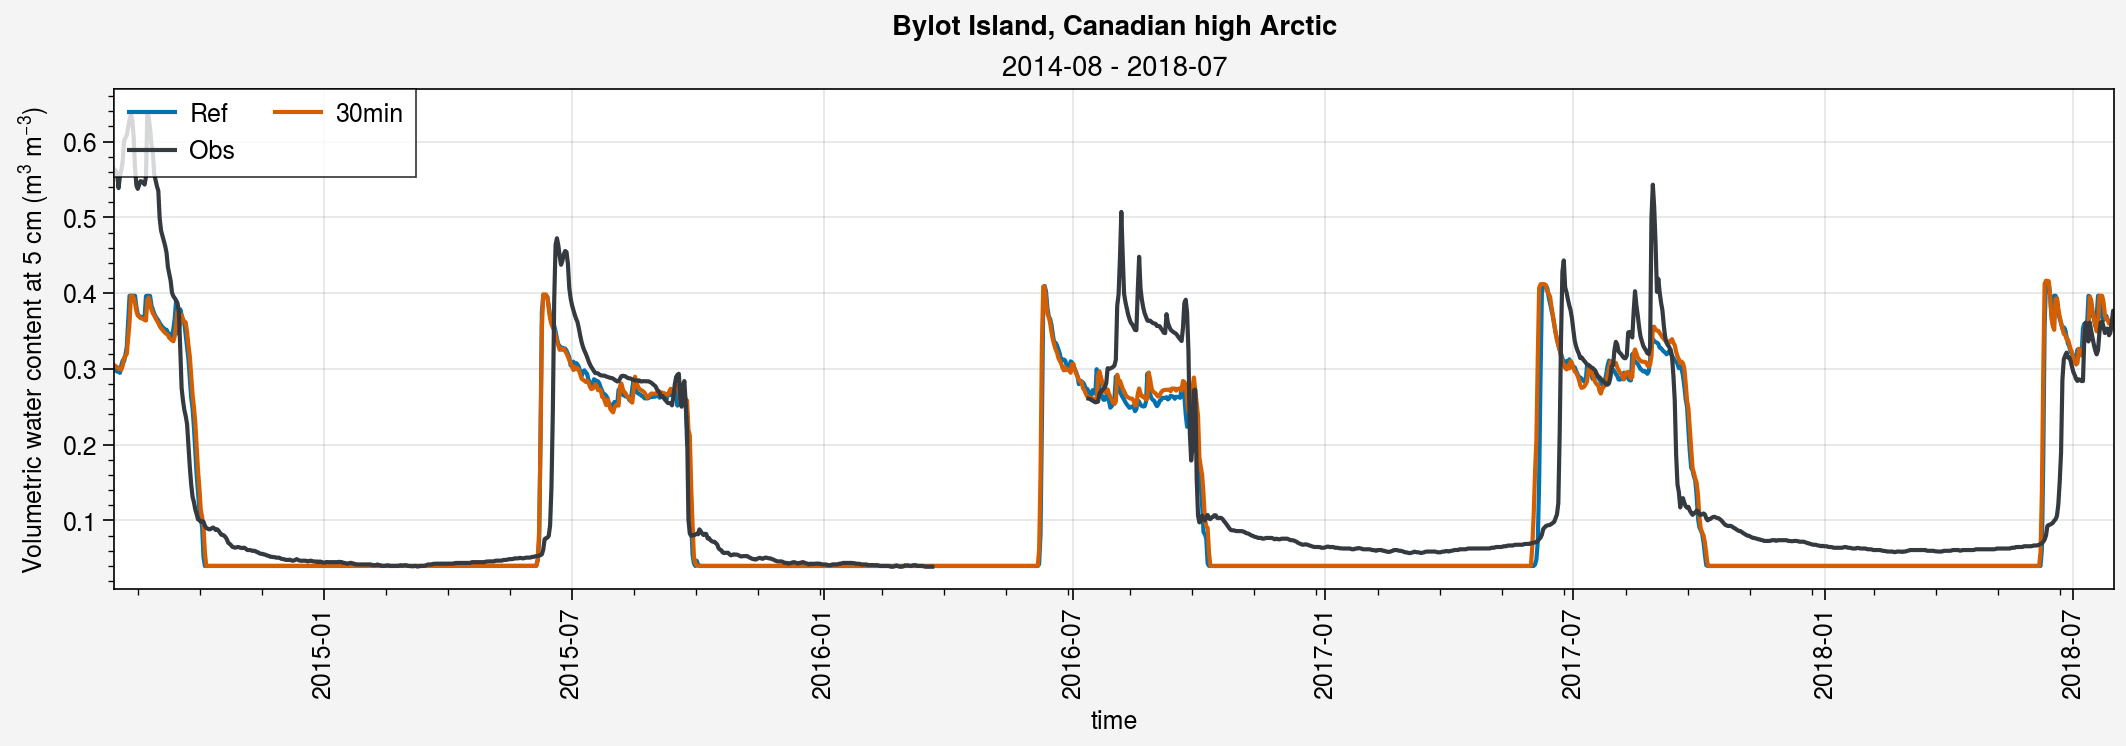

In [47]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth)/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.sel(time=period, sdepth=sdepth), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


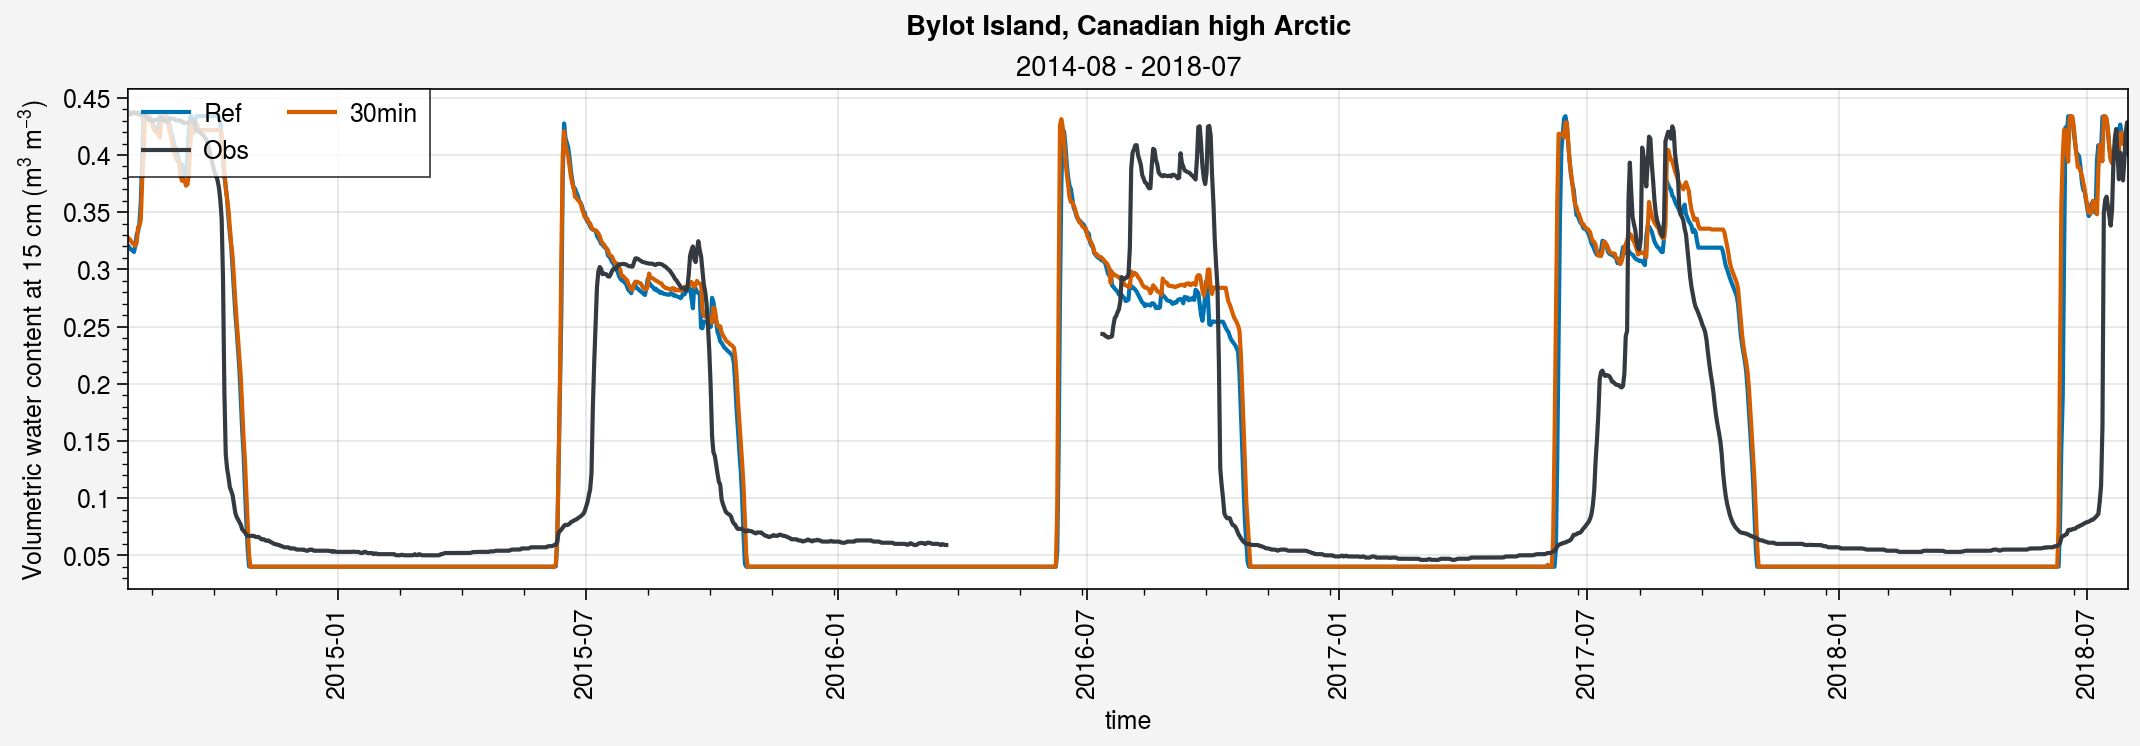

In [48]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.sel(time=period, sdepth=sdepth), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)
